# Run this cell

#### To do:
 - Try doing HP, Rect, LP and compare to the other method. 
 - What does the new frequencies mean? Can they be used to look for interesting frequencies?
 - Compare the first and last intervals. Spectral kurtosis development? Did they do that in the paper I am thinking of? 

In [131]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import numpy as np
import pandas as pd
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import sys, os

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
print("ROOT", ROOT_PATH)
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/utils/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)

import functions as f

module_path = os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)


%autoreload
import wt_data
import ff_transform
import explore_fft_time_data

ROOT /Users/stianismar/Dropbox/gitProsjekter/master-thesis/src


# Run from here

In [133]:
COMPONENT_NAME = 'GbxHssRr'

In [134]:
'''
def load_wt(wt_name):
    wt_instance = wt_data.load_instance(wt_name, load_minimal=False)
    down = []
    times = []
    number_of_intervals = len(wt_instance.ten_second_intervals)
    for i,interval in enumerate(wt_instance.ten_second_intervals):
        if i <= 5:
            vibration_signal = interval.sensor_df['GbxHssRr;0,0102;m/s2']
            time = interval.sensor_df['TimeStamp']
            times.append(time)
            # down.append((vibration_signal[::100]))
            down.append(vibration_signal)
        if i > (number_of_intervals - 5):
            print("Appending the last interval")
            vibration_signal = interval.sensor_df['GbxHssRr;0,0102;m/s2']
            down.append(vibration_signal)

            time = interval.sensor_df['TimeStamp']
            times.append(time)
    del wt_instance
    del interval
    return down, times

vib_signal_wt4, times_wt4 = load_wt("WTG04")

from numpy import savez_compressed
savez_compressed('../../sensor_data/vib_signal_wt4.npz', vib_signal_wt4)
savez_compressed('../../sensor_data/times_wt4.npz', times_wt4)

del vib_signal_wt4, times_wt4
'''

'\ndef load_wt(wt_name):\n    wt_instance = wt_data.load_instance(wt_name, load_minimal=False)\n    down = []\n    times = []\n    number_of_intervals = len(wt_instance.ten_second_intervals)\n    for i,interval in enumerate(wt_instance.ten_second_intervals):\n        if i <= 5:\n            vibration_signal = interval.sensor_df[\'GbxHssRr;0,0102;m/s2\']\n            time = interval.sensor_df[\'TimeStamp\']\n            times.append(time)\n            # down.append((vibration_signal[::100]))\n            down.append(vibration_signal)\n        if i > (number_of_intervals - 5):\n            print("Appending the last interval")\n            vibration_signal = interval.sensor_df[\'GbxHssRr;0,0102;m/s2\']\n            down.append(vibration_signal)\n\n            time = interval.sensor_df[\'TimeStamp\']\n            times.append(time)\n    del wt_instance\n    del interval\n    return down, times\n\nvib_signal_wt4, times_wt4 = load_wt("WTG04")\n\nfrom numpy import savez_compressed\nsavez_comp

In [135]:
from numpy import load

# Load compressed data
vib_signal_wt4 = load('../../sensor_data/vib_signal_wt4.npz')
times_wt4 = load('../../sensor_data/times_wt4.npz')

In [136]:
vib_signal_wt4 = vib_signal_wt4['arr_0']
times_wt4 = times_wt4['arr_0']

In [137]:
print(vib_signal_wt4.shape)
print(times_wt4.shape)

(10, 262144)
(10, 262144)


In [138]:
from scipy import stats
stats.describe(vib_signal_wt4[2])

DescribeResult(nobs=262144, minmax=(1140.154670267, 1254.097433651), mean=1197.8798405171483, variance=156.36851298741024, skewness=-0.012513486195968326, kurtosis=0.03141294128650163)

5
2359296


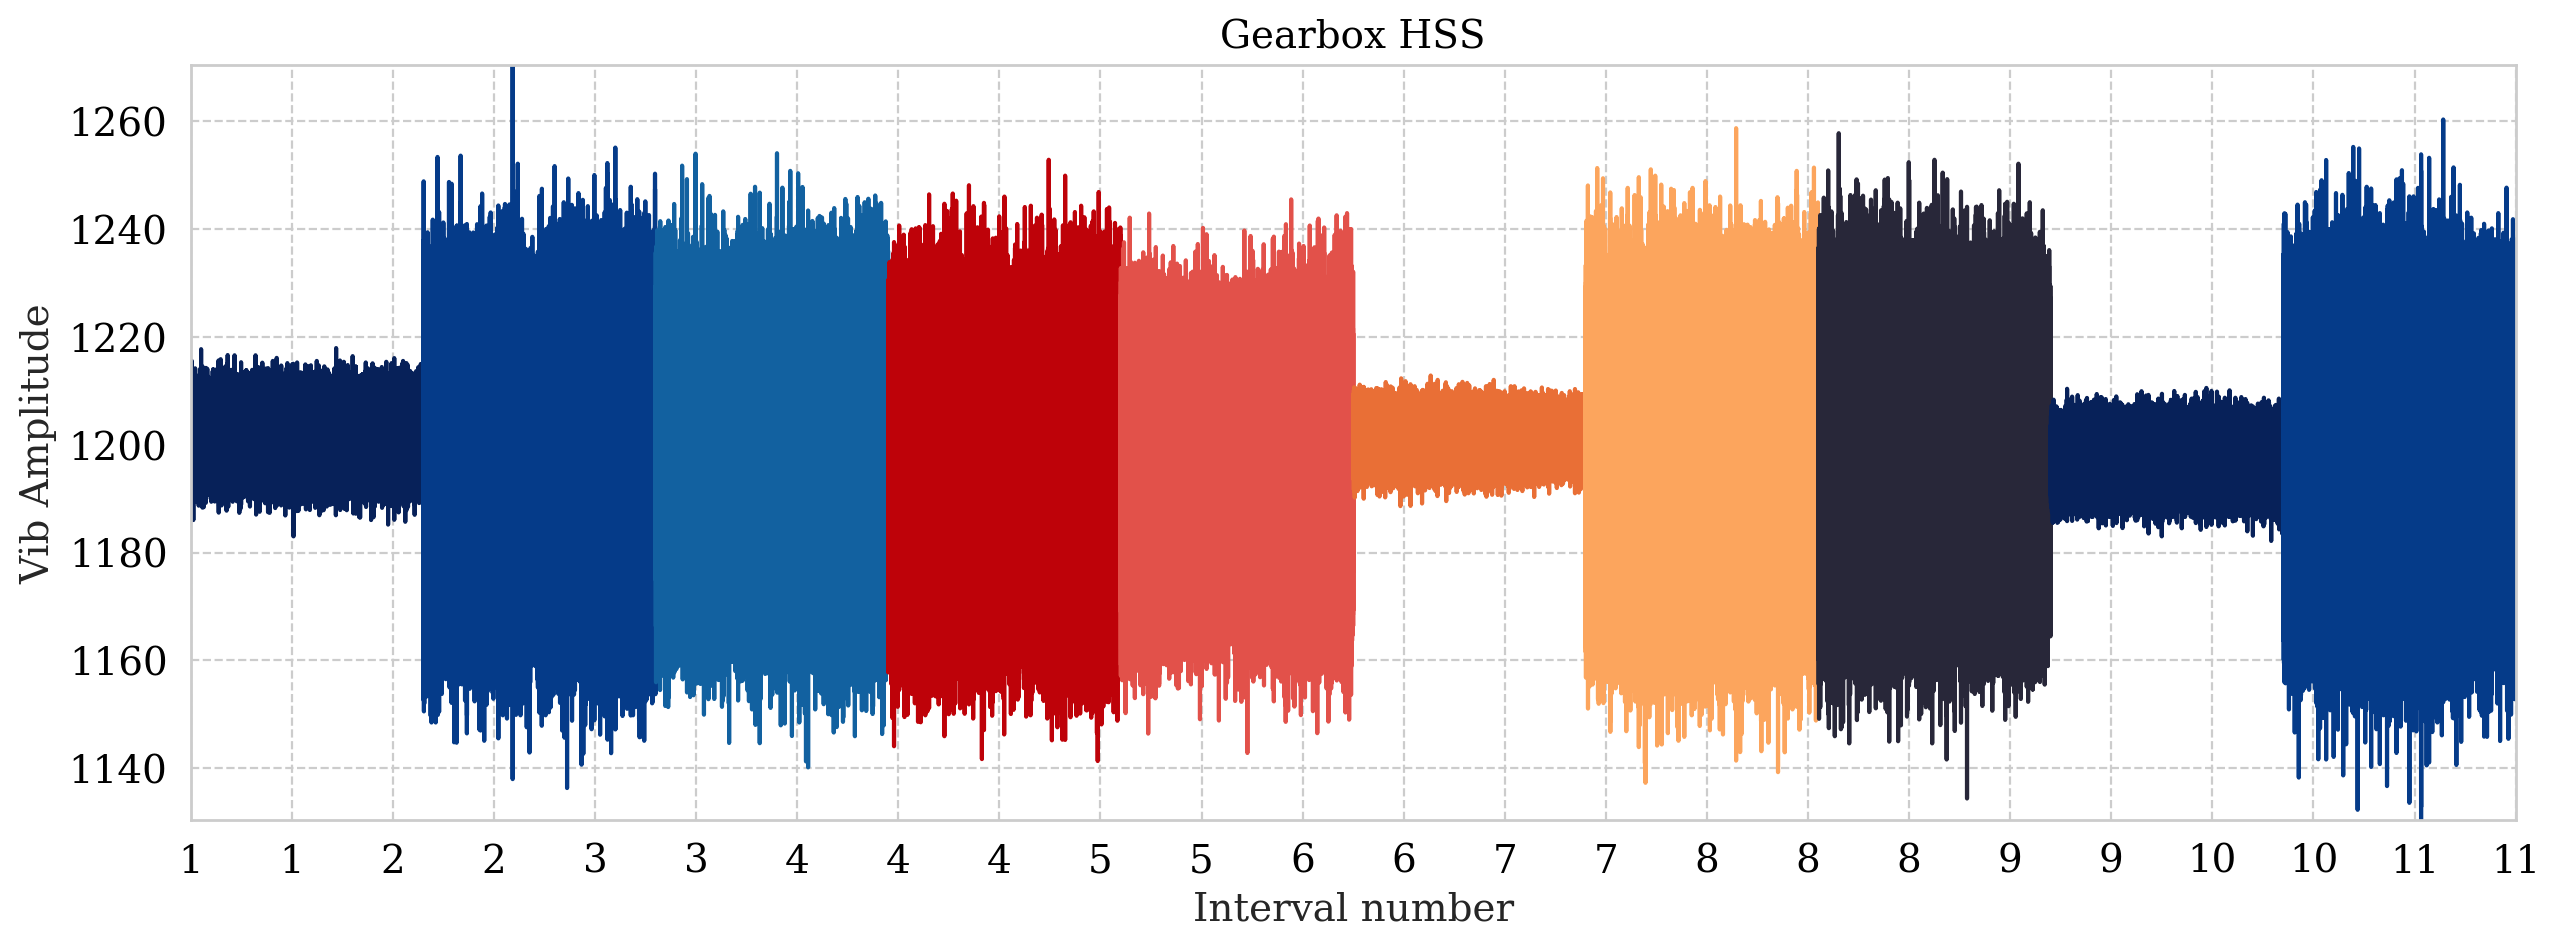

In [139]:
def plot_vib_consecutive(down):
    indexes = []
    index_start=0
    fig, ax = plt.subplots(figsize=(15,5))
    for i, d in enumerate(down):
        indexes.append(index_start)
        index_end = len(d)
        x = np.arange(index_start, index_start+index_end)
        index_start = len(x) + index_start
        plt.plot(x,d)
        plt.margins(0)
    print(len(np.linspace(0,index_start+index_end,5)))
    plt.xticks(np.linspace(0,index_start,24),[int(round(elem)) for i,elem in enumerate(np.linspace(1,len(down)+1,24))])
    #locs, labels = plt.xticks()
    #ax.set_xticks(indexes)
    #ax.set_xticklabels(np.arange(1,len(indexes)+1))
    # plt.xticks(fontsize=7, rotation=90)
    print((indexes[-1]))
    plt.title("Gearbox HSS")
    plt.xlabel("Interval number")
    plt.ylabel("Vib Amplitude")
    plt.show()
plot_vib_consecutive(vib_signal_wt4)

In [140]:
def get_sampling_freq(signal,times):
    for i in range(len(np.array(times))):
        times = np.array(times)
        T = times[0] - times[1]
        ending_time = np.array(times)[-1]
        N = len(signal)
        fs = N/ending_time
        break
    return fs, N, T, ending_time

fs, N, T, ending_time = get_sampling_freq(vib_signal_wt4[0],times_wt4[0])
fs

25600.097656622533

In [141]:
def perform_fft(amplitudes, timestamps,ax ):
    t = timestamps
    sig = amplitudes
    mean_amplitude = np.mean(sig)
    sig = sig - mean_amplitude  # Centering around 0
    fft = np.fft.fft(sig)
    N = sig.size
    T = t[1] - t[0]

    f = np.linspace(0, 1 / T, N, )  # start, stop, number of. 1 / T = frequency is the biggest freq

    f = f[:N // 2]
    y = np.abs(fft)[:N // 2]
    y_norm = np.abs(fft)[:N // 2] * 1 / N  # Normalized
    fft_modulus_norm = y_norm
    ax.plot(f,fft_modulus_norm)

# perform_fft(sig, t)

In [142]:
'''
****** HIGHPASS FUNCTION ******
'''

import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
def sine_generator(fs, sinefreq, duration):
    T = duration
    nsamples = fs * T
    w = 2. * np.pi * sinefreq
    t_sine = np.linspace(0, T, nsamples, endpoint=False)
    y_sine = np.sin(w * t_sine)
    result = pd.DataFrame({ 
        'data' : y_sine} ,index=t_sine)
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# fps = 2000
#sine_fq = 10 #Hz
duration = ending_time #seconds
#sine_5Hz = sine_generator(fps,sine_fq,duration)
#sine_fq = 1 #Hz
duration = ending_time #seconds
# sine_1Hz = sine_generator(fps,sine_fq,duration)

# sine = sine_5Hz + sine_1Hz
hp_cutoff = 2000
filtered_sine_wt4 = butter_highpass_filter(vib_signal_wt4[0],hp_cutoff,fs)
filtered_sine_wt4

array([ 0.02693668, -8.03137194,  2.73915928, ..., -0.36603239,
       -1.51398821,  0.12156179])

## Butter bandpass

In [143]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

## Plot_enveloping_process

In [144]:
def plot_enveloping_process(rows, cols, COMPONENT_NAME, raw_signal, filtred_signal, filtered_rect, timestamps, lowcut, highcut):
    filtred_signal
    fig, ax = plt.subplots(rows, cols)
    fig.suptitle(f'{COMPONENT_NAME}: Envelop signal processing ',fontsize=16, y=1.05)

    ax[0,0].plot(timestamps,raw_signal)
    ax[0,0].set_title(f"Raw vibration signal from {COMPONENT_NAME} ")
    perform_fft(raw_signal,timestamps,ax[0,1])
    ax[0,1].set_xlabel("Frequency [Hz]")
    ax[0,1].set_title(f"Raw signal from {COMPONENT_NAME}")

    ax[1,0].plot(timestamps,filtred_signal)
    ax[1,0].set_title(f'filtered signal with lower cutoff {lowcut} and higher {highcut} Hz')
    perform_fft(filtred_signal, timestamps, ax[1,1])
    ax[1,1].set_xlabel("Frequency [Hz]")
    ax[1,1].set_xlim(lowcut-500,highcut+500)
    
    ax[2,0].plot(timestamps,filtered_rect)
    ax[2,0].set_title(f'Rectified the bandpass-filtered')
    perform_fft(filtered_rect, timestamps, ax[2,1])
    ax[2,1].set_xlabel("Frequency [Hz]")
    # ax[2,1].set_xlim(0,1000)    
    
    plt.tight_layout()
    plt.margins(0)

## lowcut = 4000, highcut = 6000
### First interval

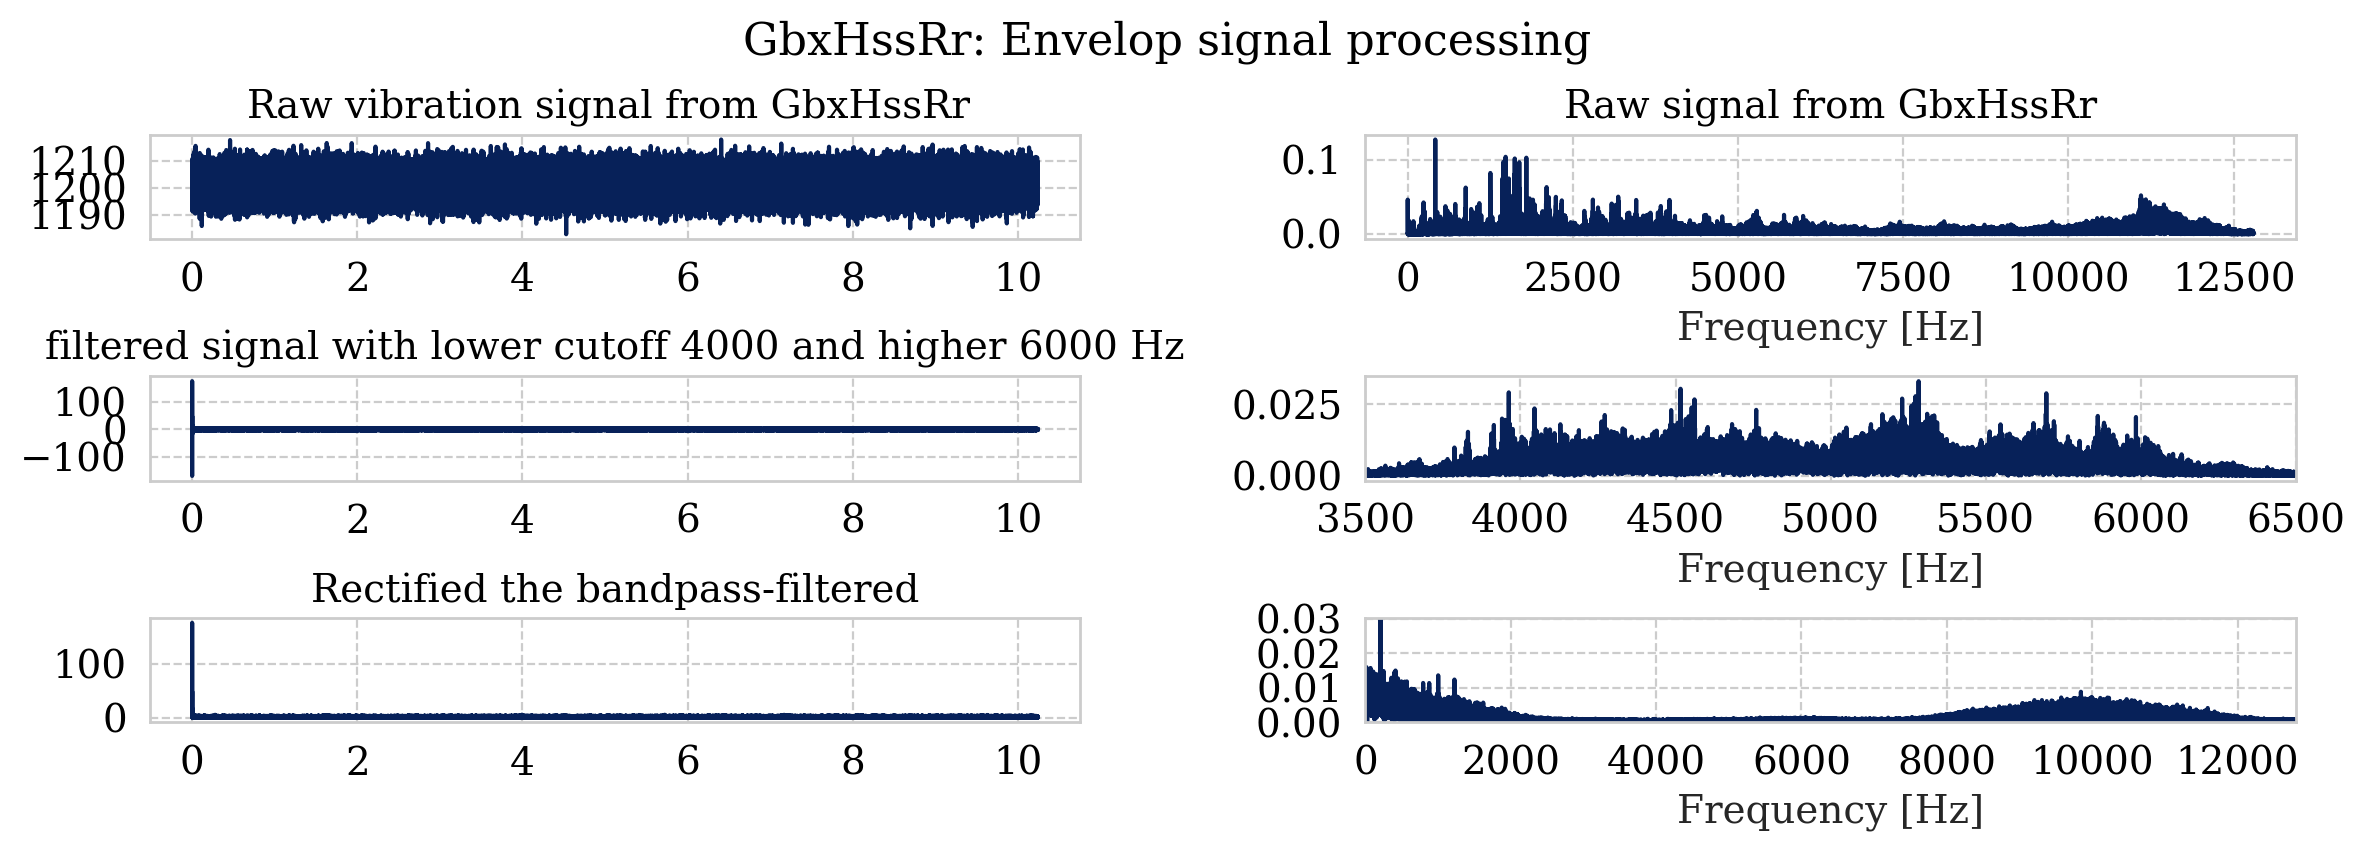

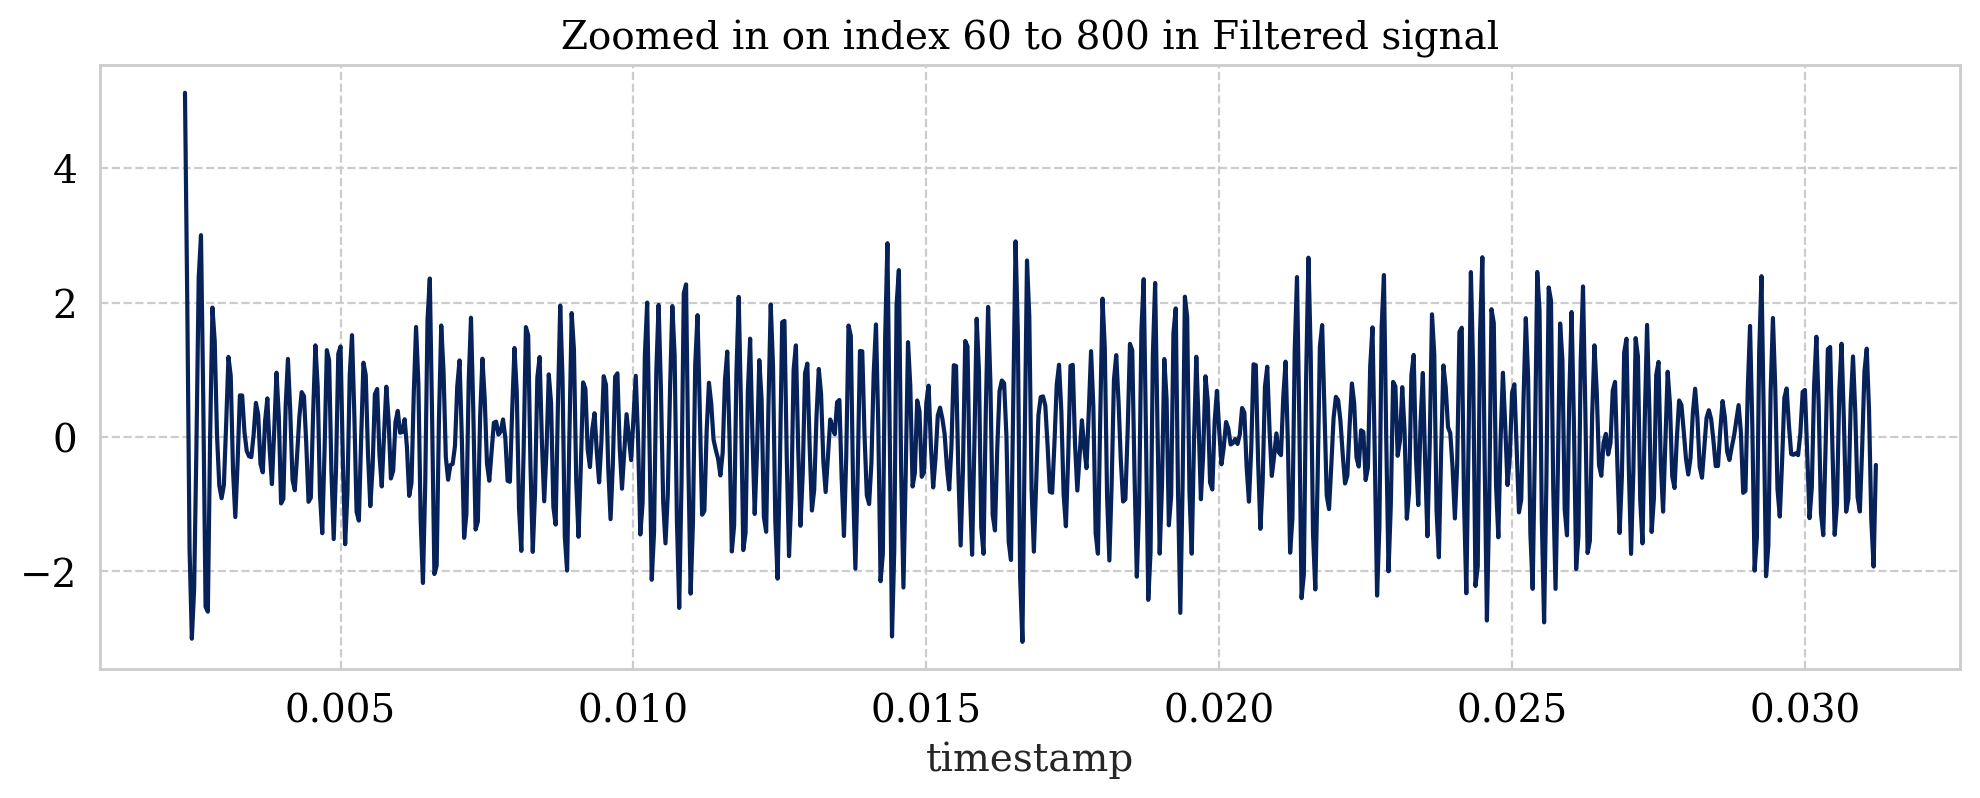

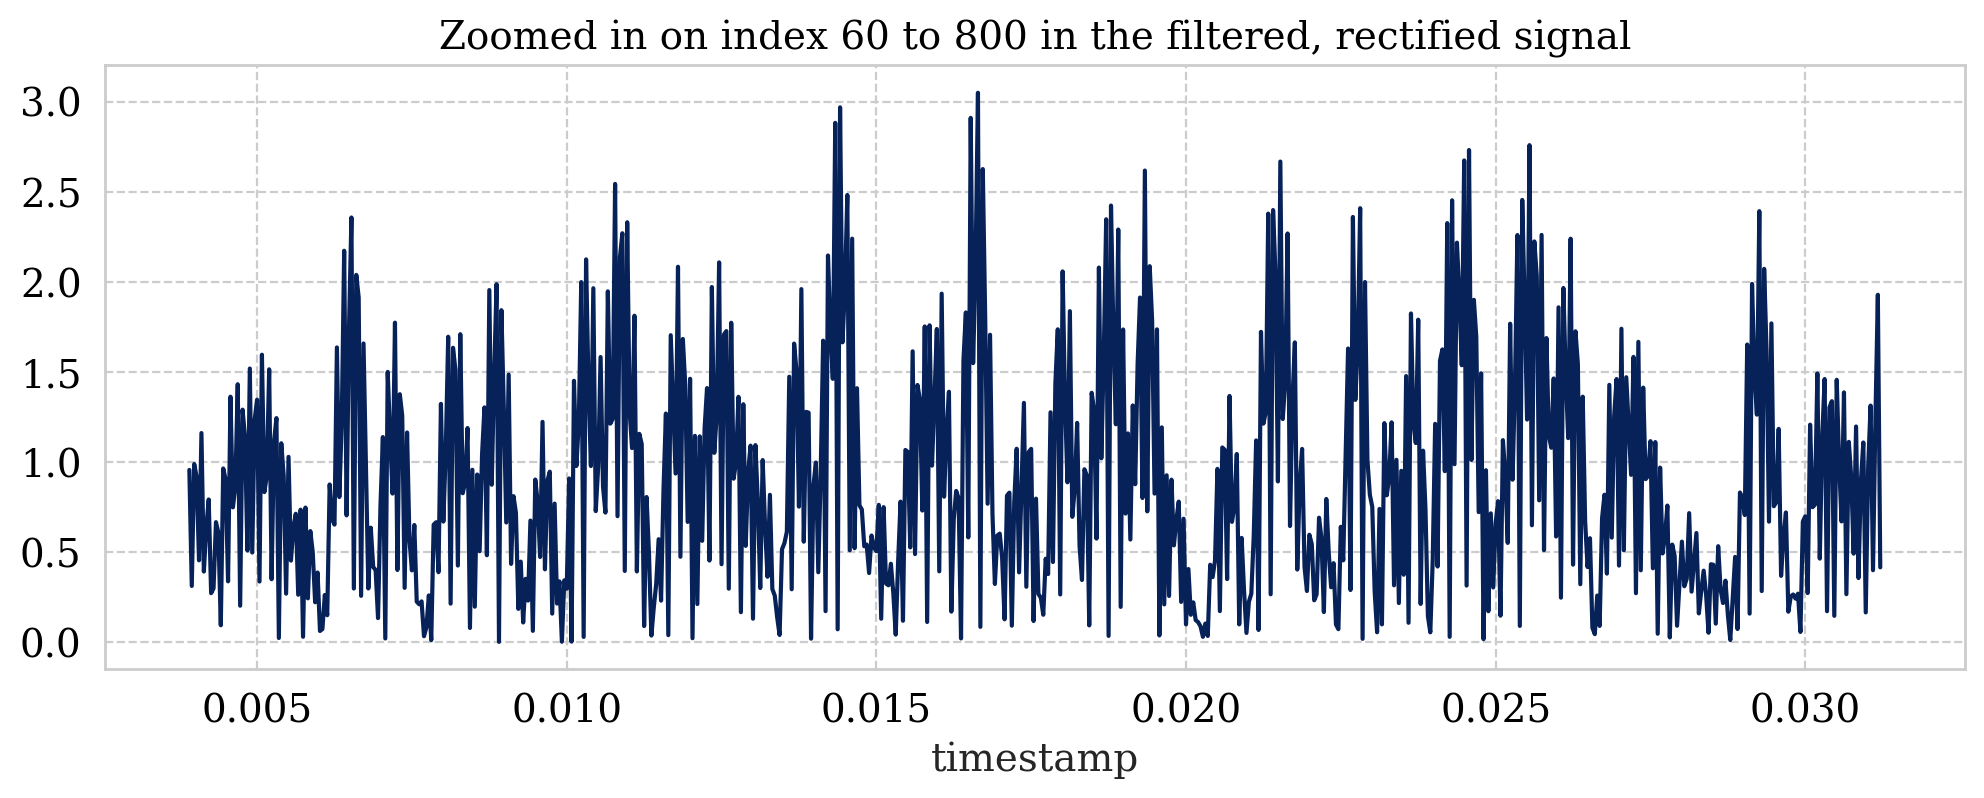

In [156]:
lowcut = 4000
highcut = 6000
perform_envelope_process(times_wt4[0],vib_signal_wt4[0], fs,'GbxHssRr', lowcut, highcut)

### Last interval

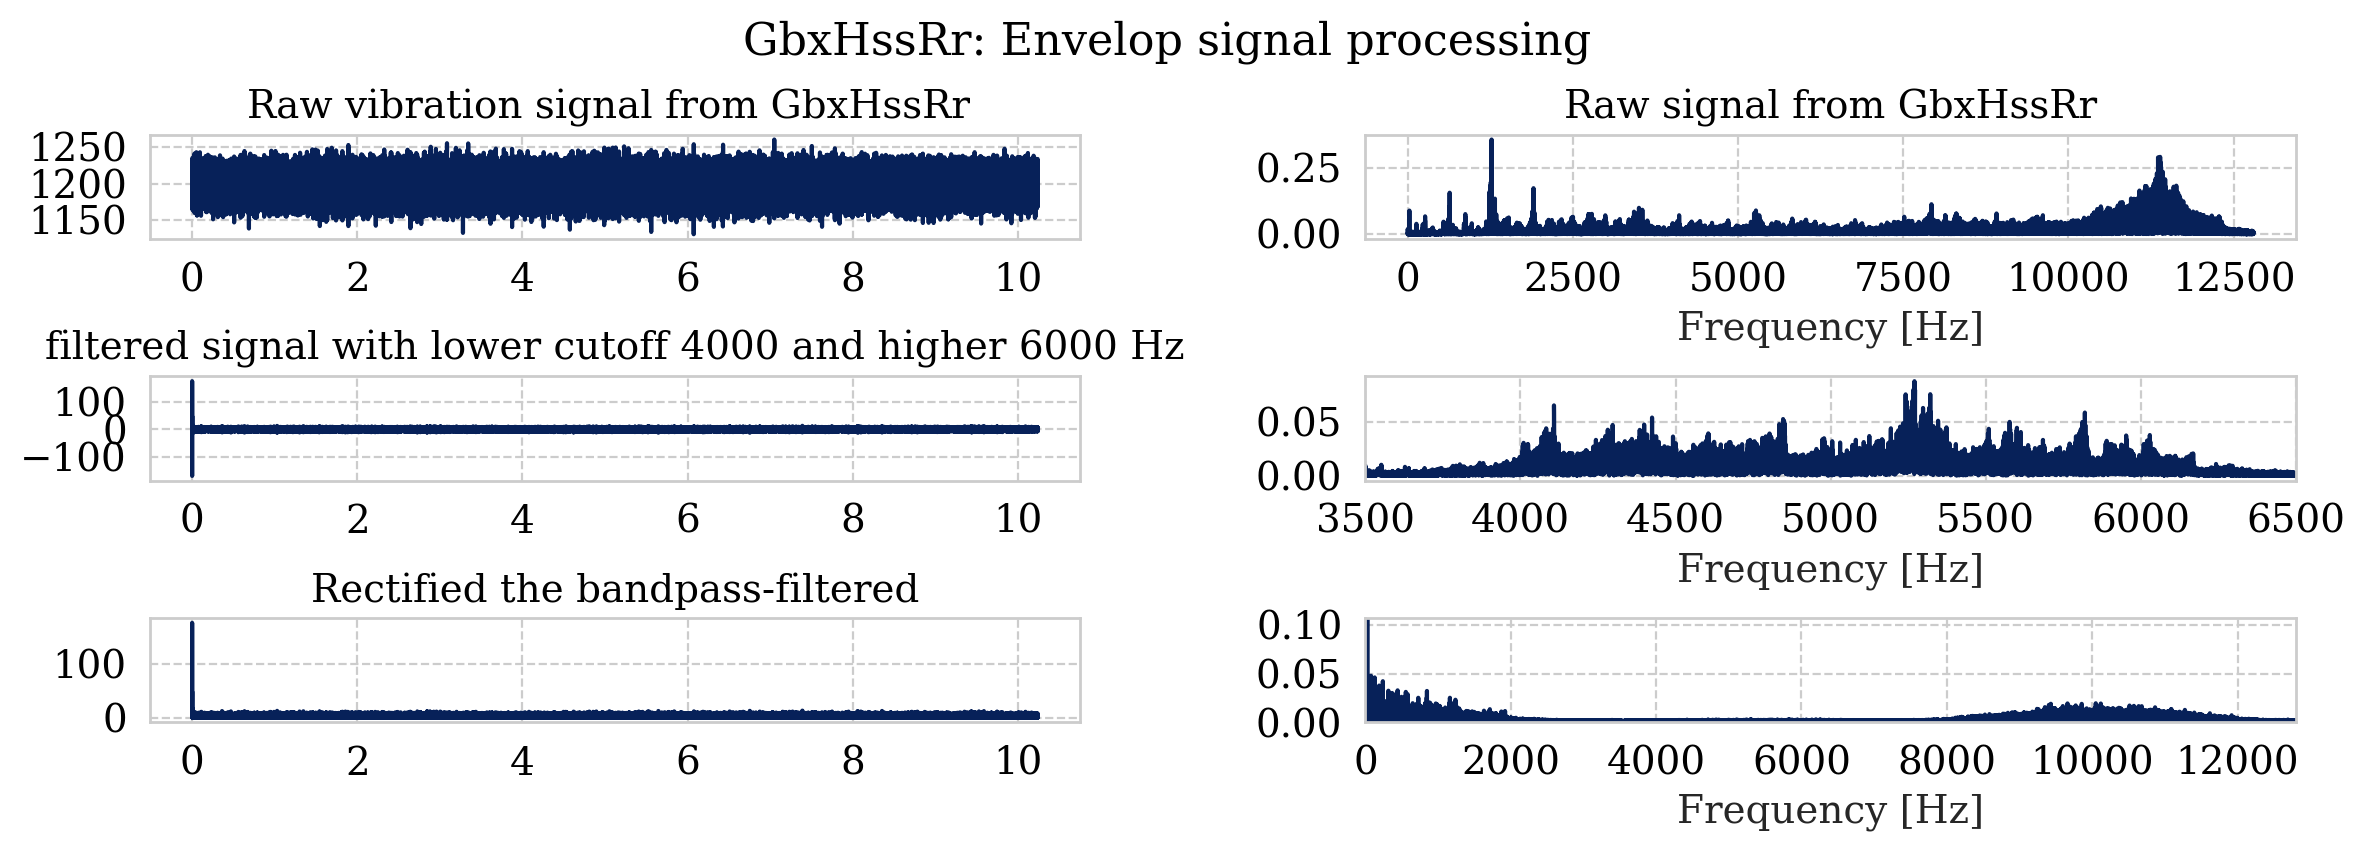

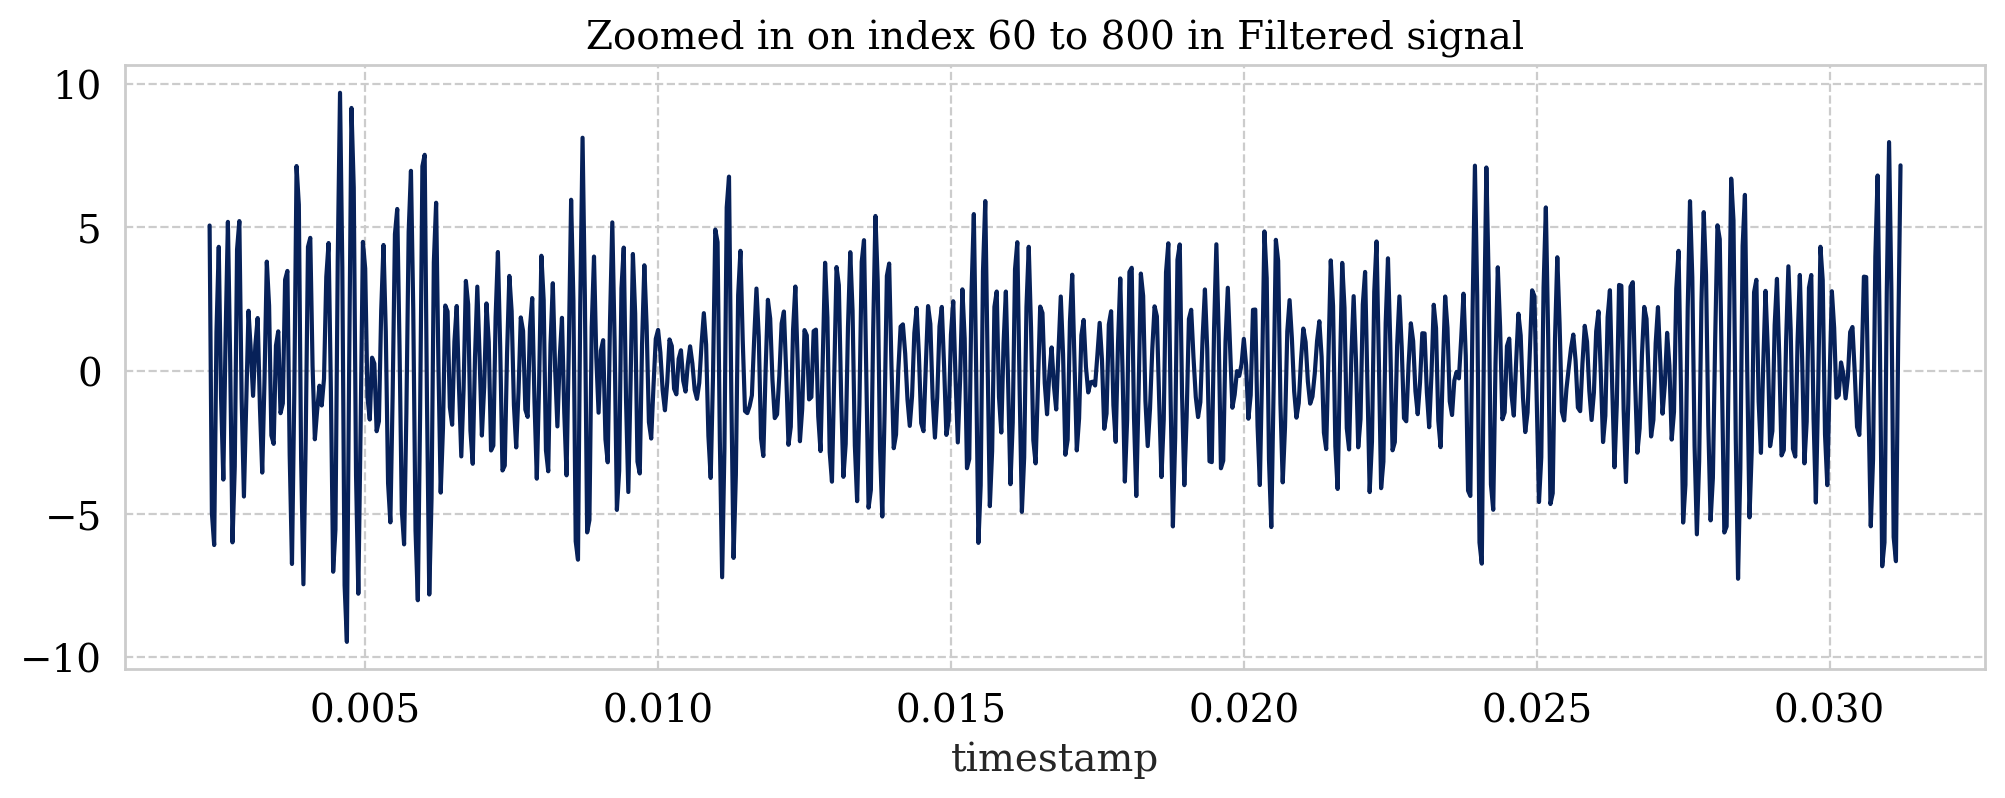

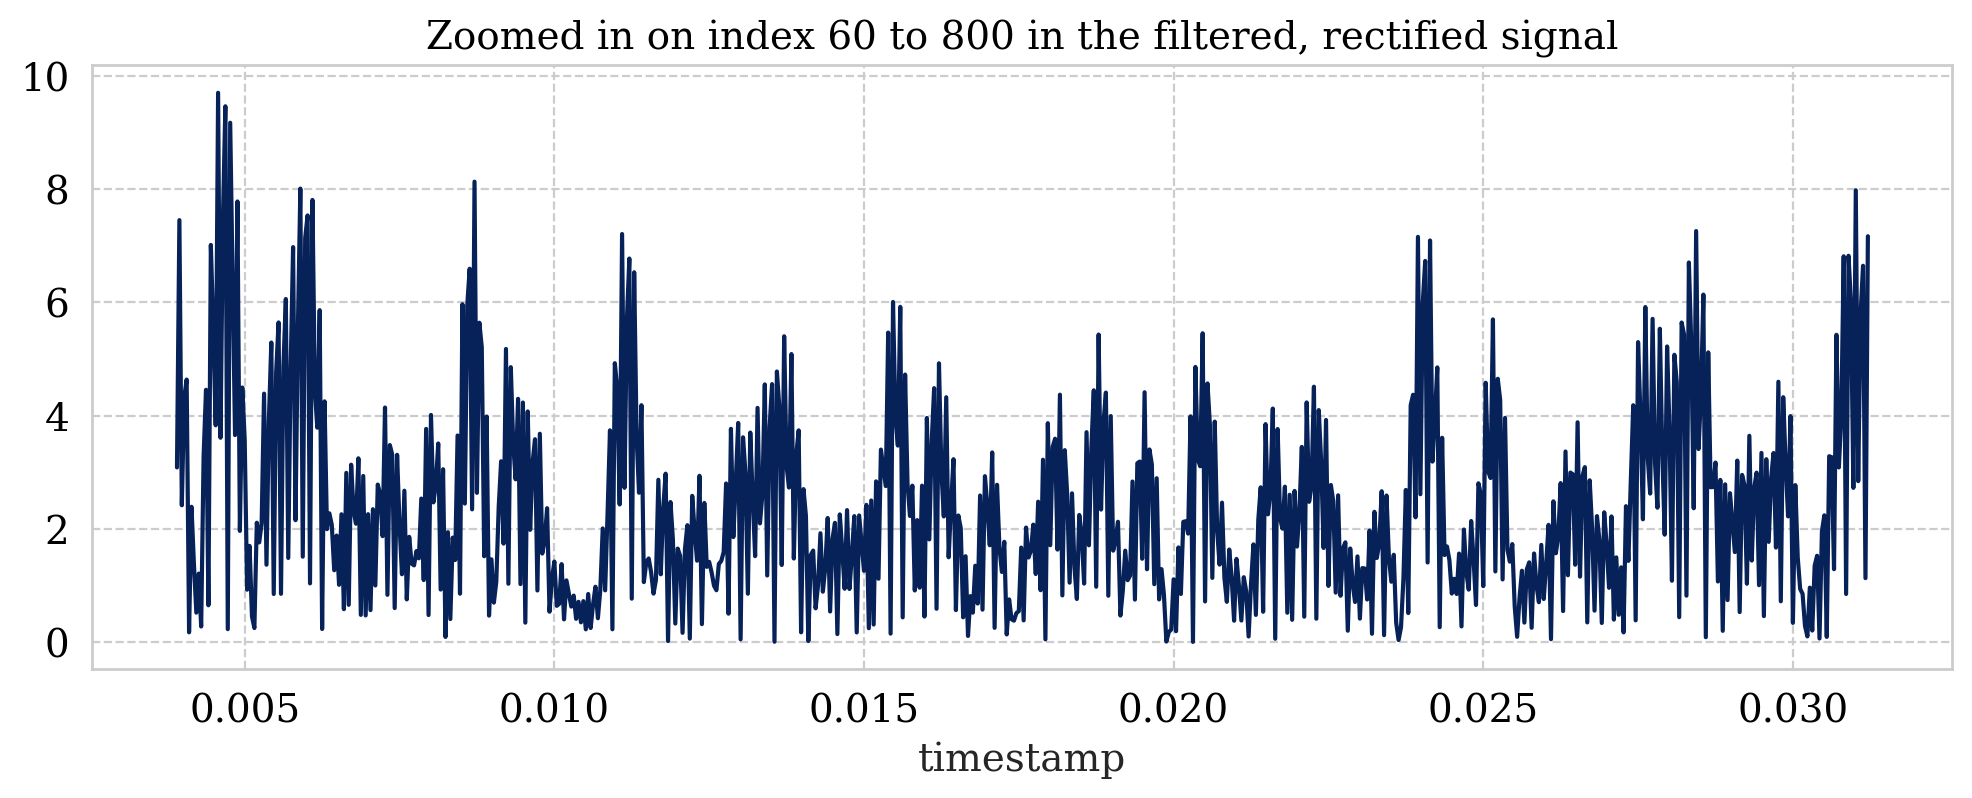

In [155]:
def perform_envelope_process(timestamps, interval_signal,fs, COMPONENT_NAME, lowcut,highcut,order = 5,):
    fs, _, _ ,_ =  get_sampling_freq(interval_signal,timestamps)
    bandpass_filtered = butter_bandpass_filter(interval_signal,lowcut, highcut, fs, order=5)
    bandpass_filtered_rect = abs(bandpass_filtered)
    plot_enveloping_process(3,2,COMPONENT_NAME, interval_signal,bandpass_filtered,bandpass_filtered_rect,timestamps,lowcut,highcut )

    df = pd.DataFrame(bandpass_filtered)
    df['timestamp'] = timestamps
    # df.plot.hist(bins=2000)
    df.iloc[60:800].plot.line(x='timestamp',y=0,title="Zoomed in on index 60 to 800 in Filtered signal",legend=False)
    
    df = pd.DataFrame(bandpass_filtered_rect)
    df['timestamp'] = timestamps
    # df.plot.hist(bins=2000)
    df.iloc[100:800].plot.line(x='timestamp',y=0,title="Zoomed in on index 60 to 800 in the filtered, rectified signal",legend=False)
    


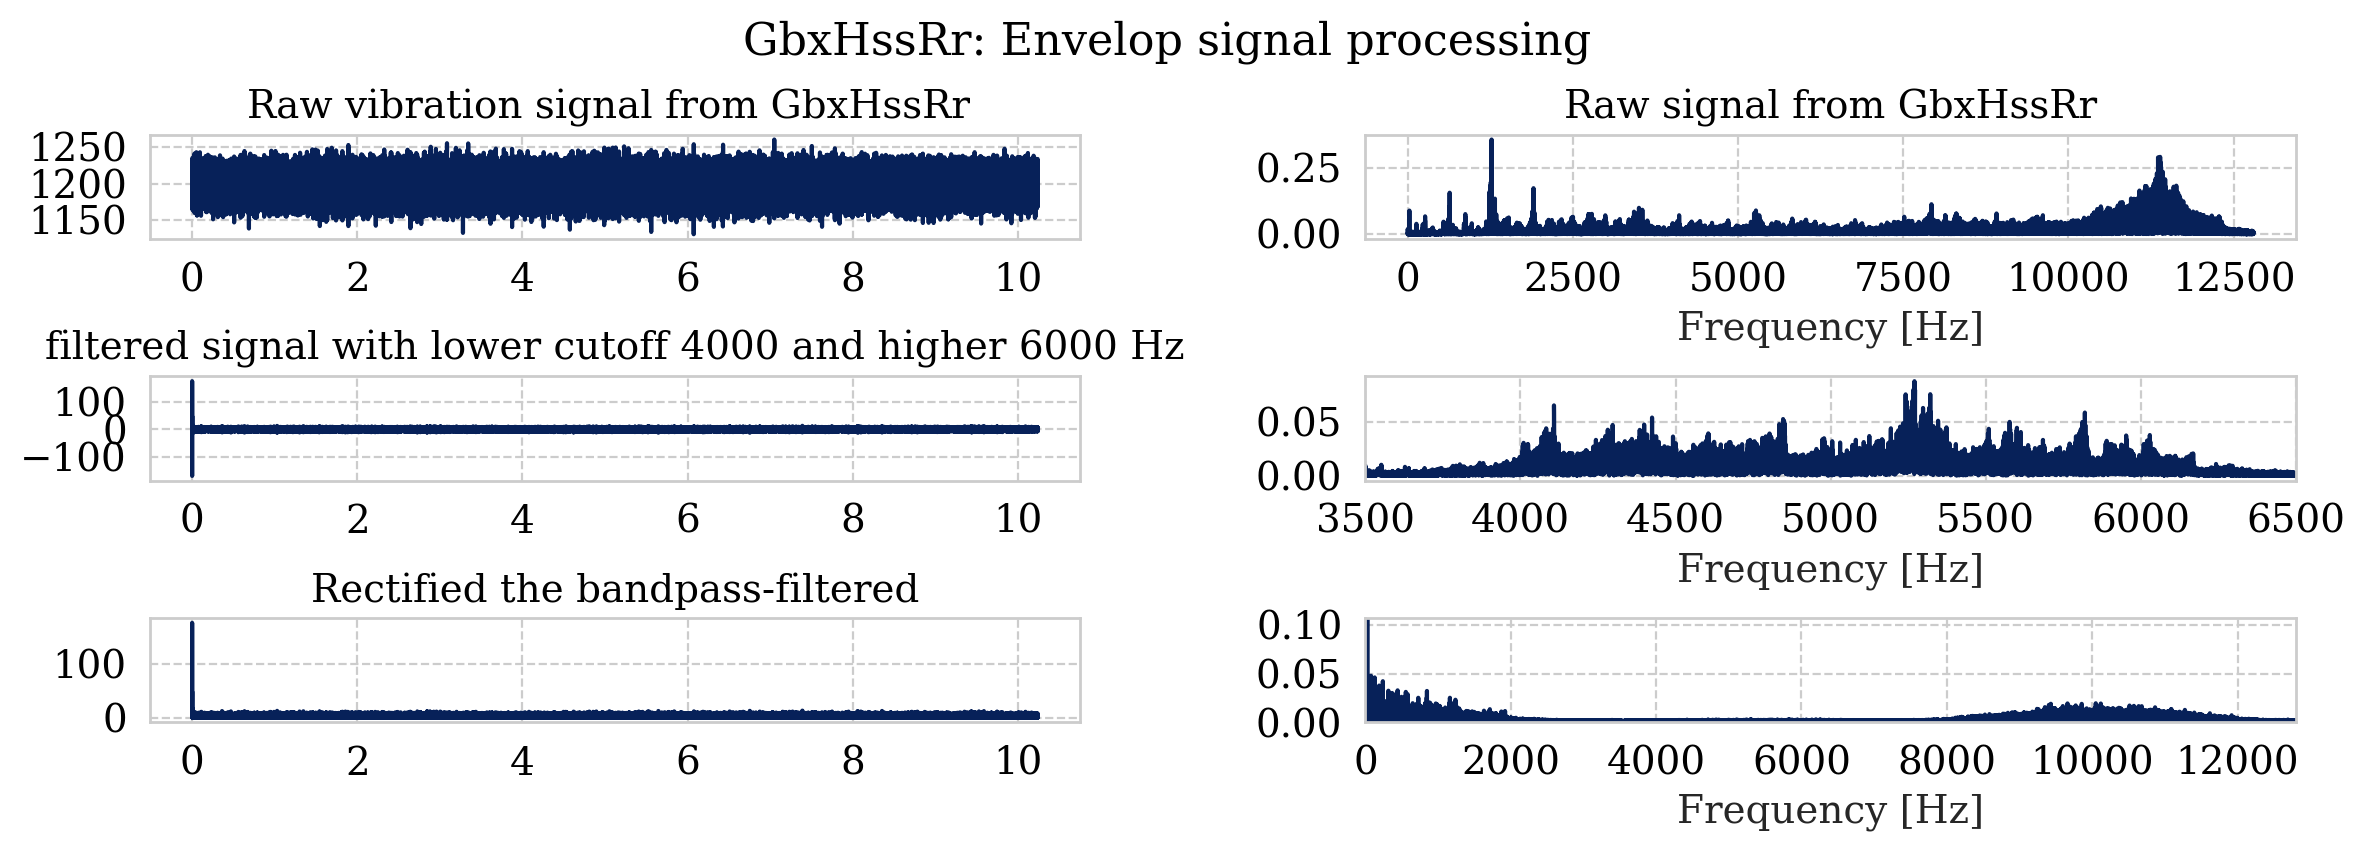

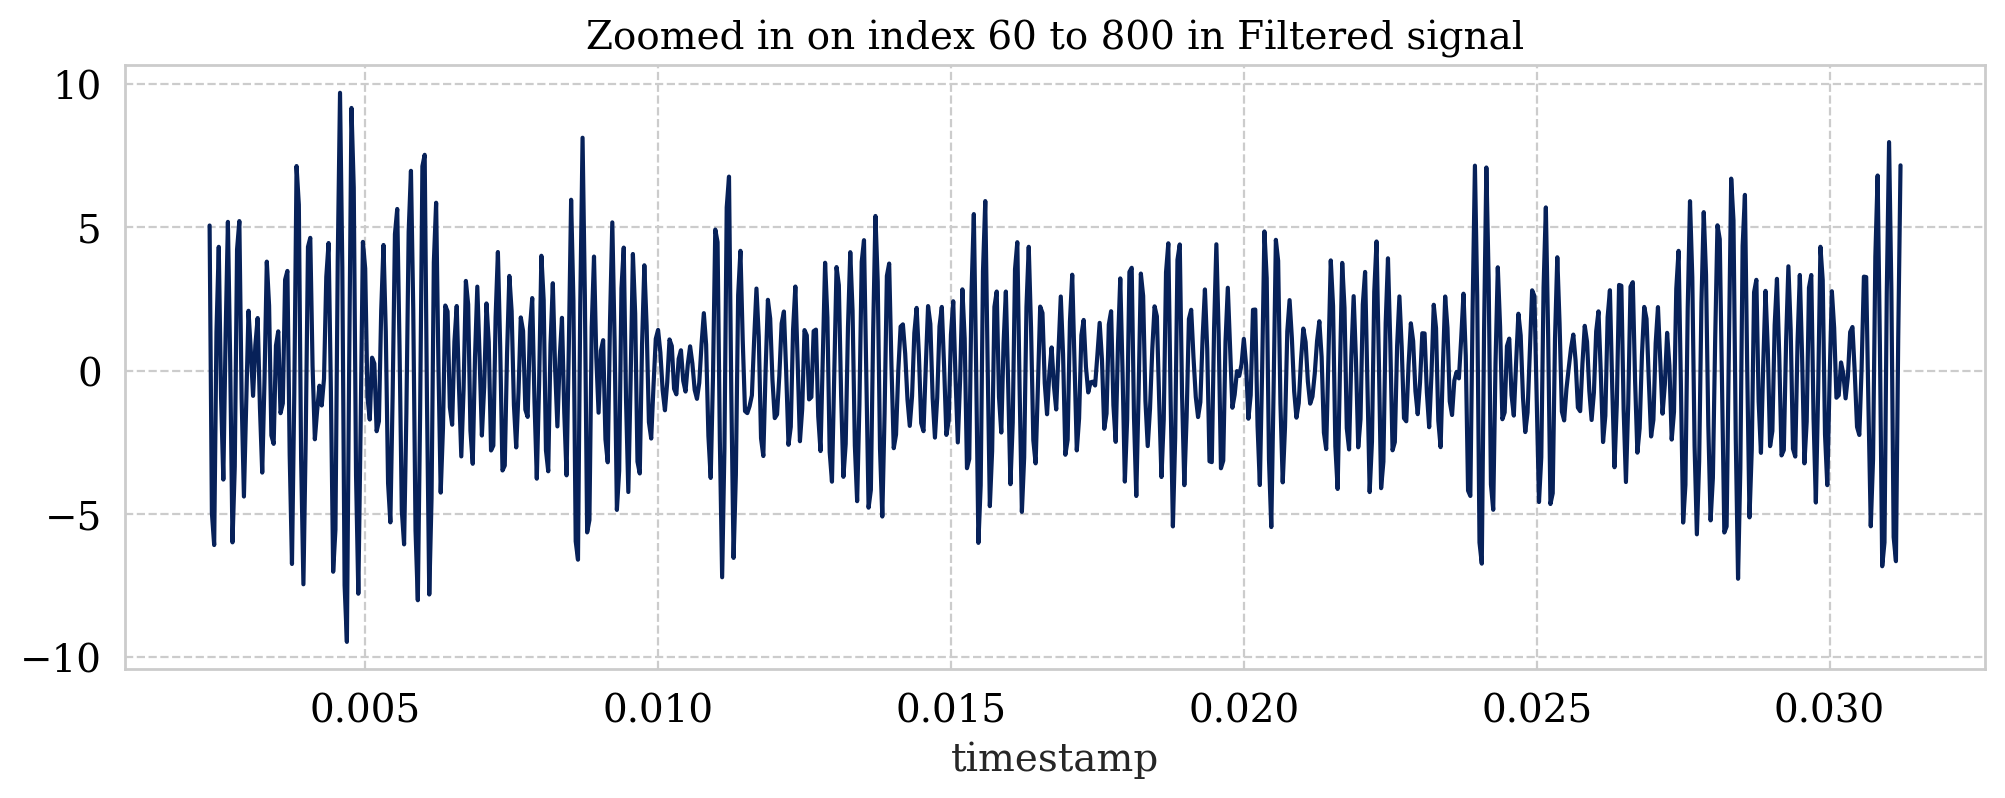

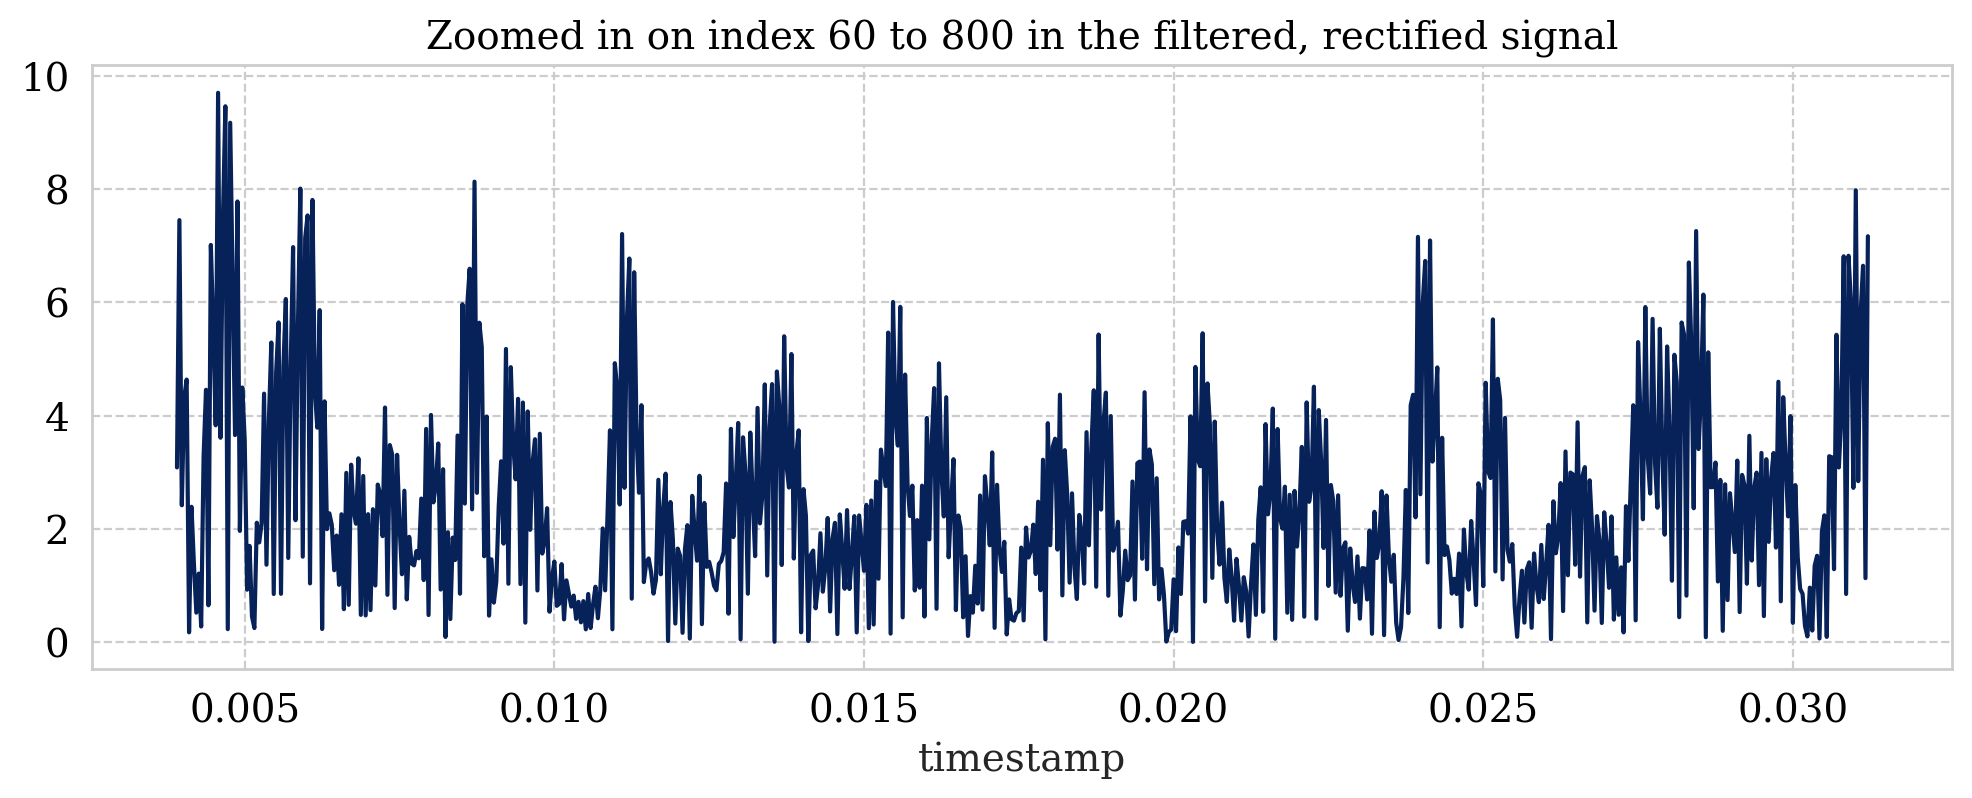

In [157]:
lowcut = 4000
highcut = 6000
perform_envelope_process(times_wt4[-1],vib_signal_wt4[-1], fs,'GbxHssRr', lowcut, highcut)

### Second to last interval

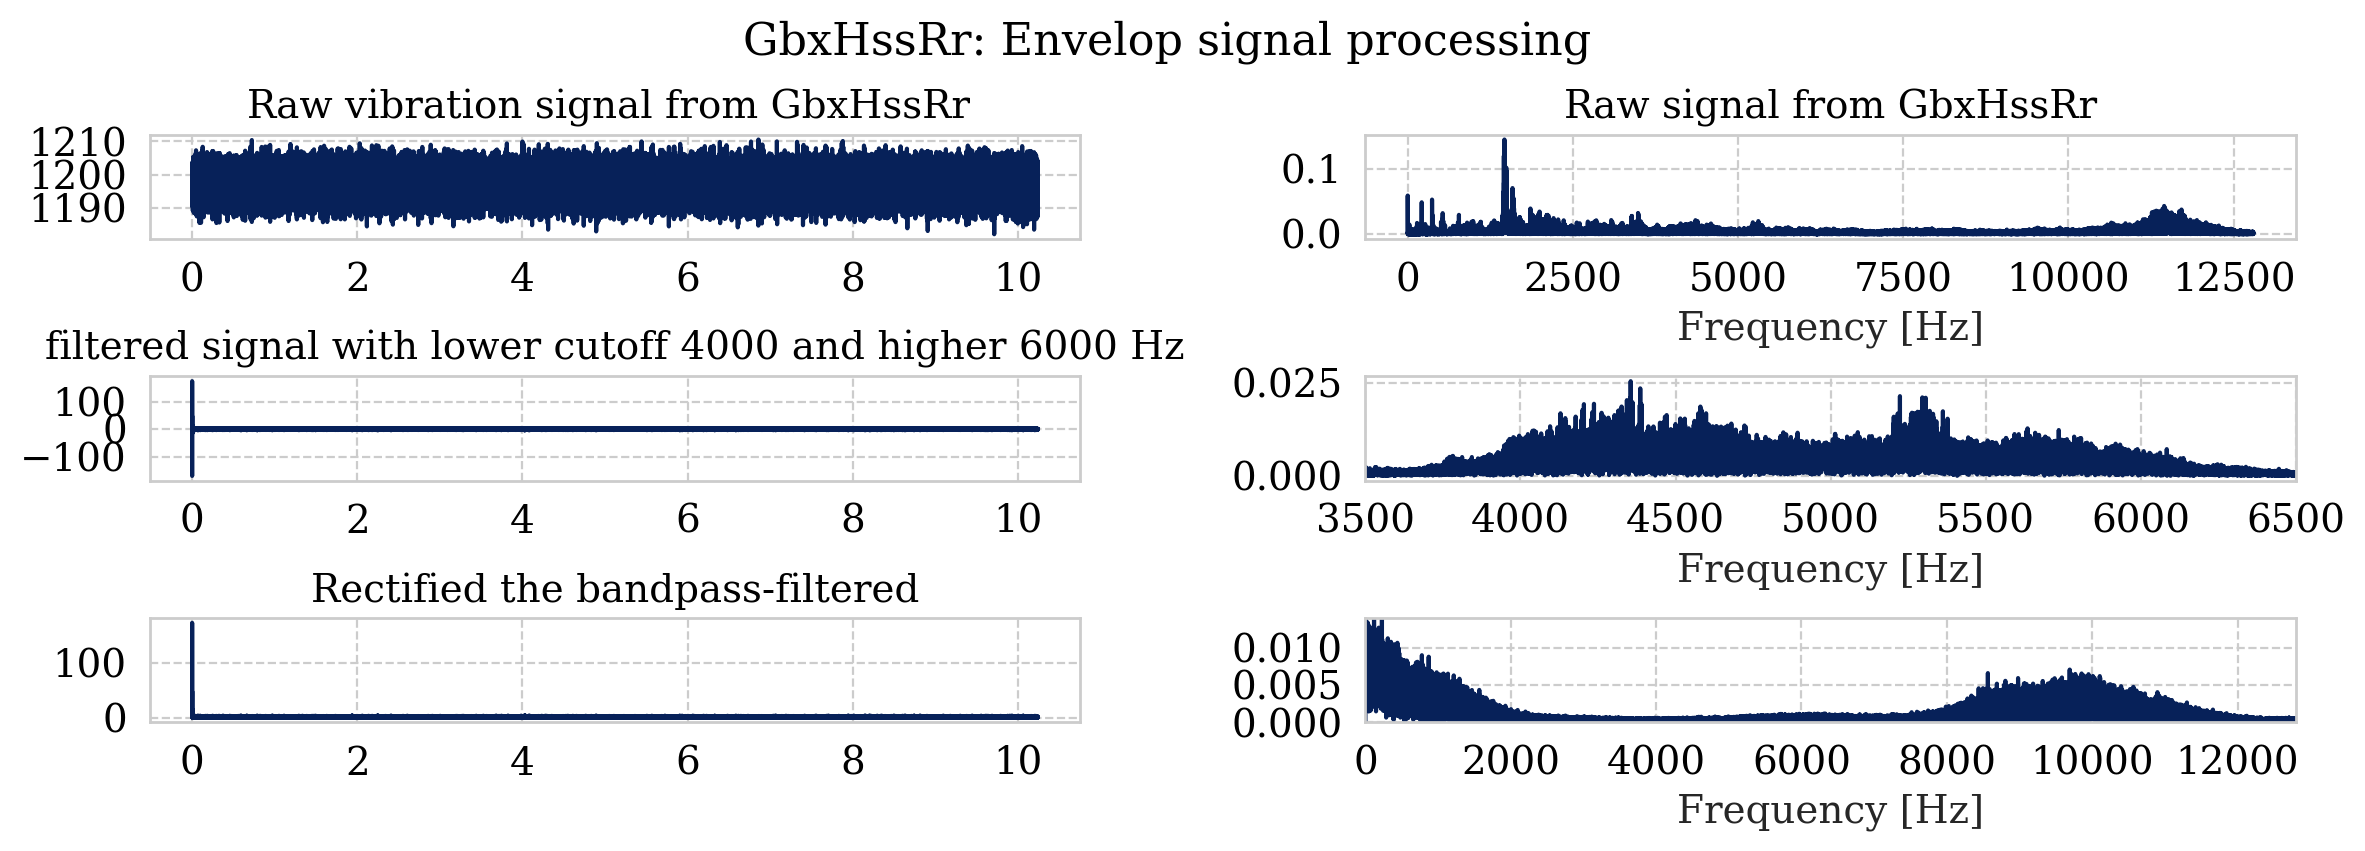

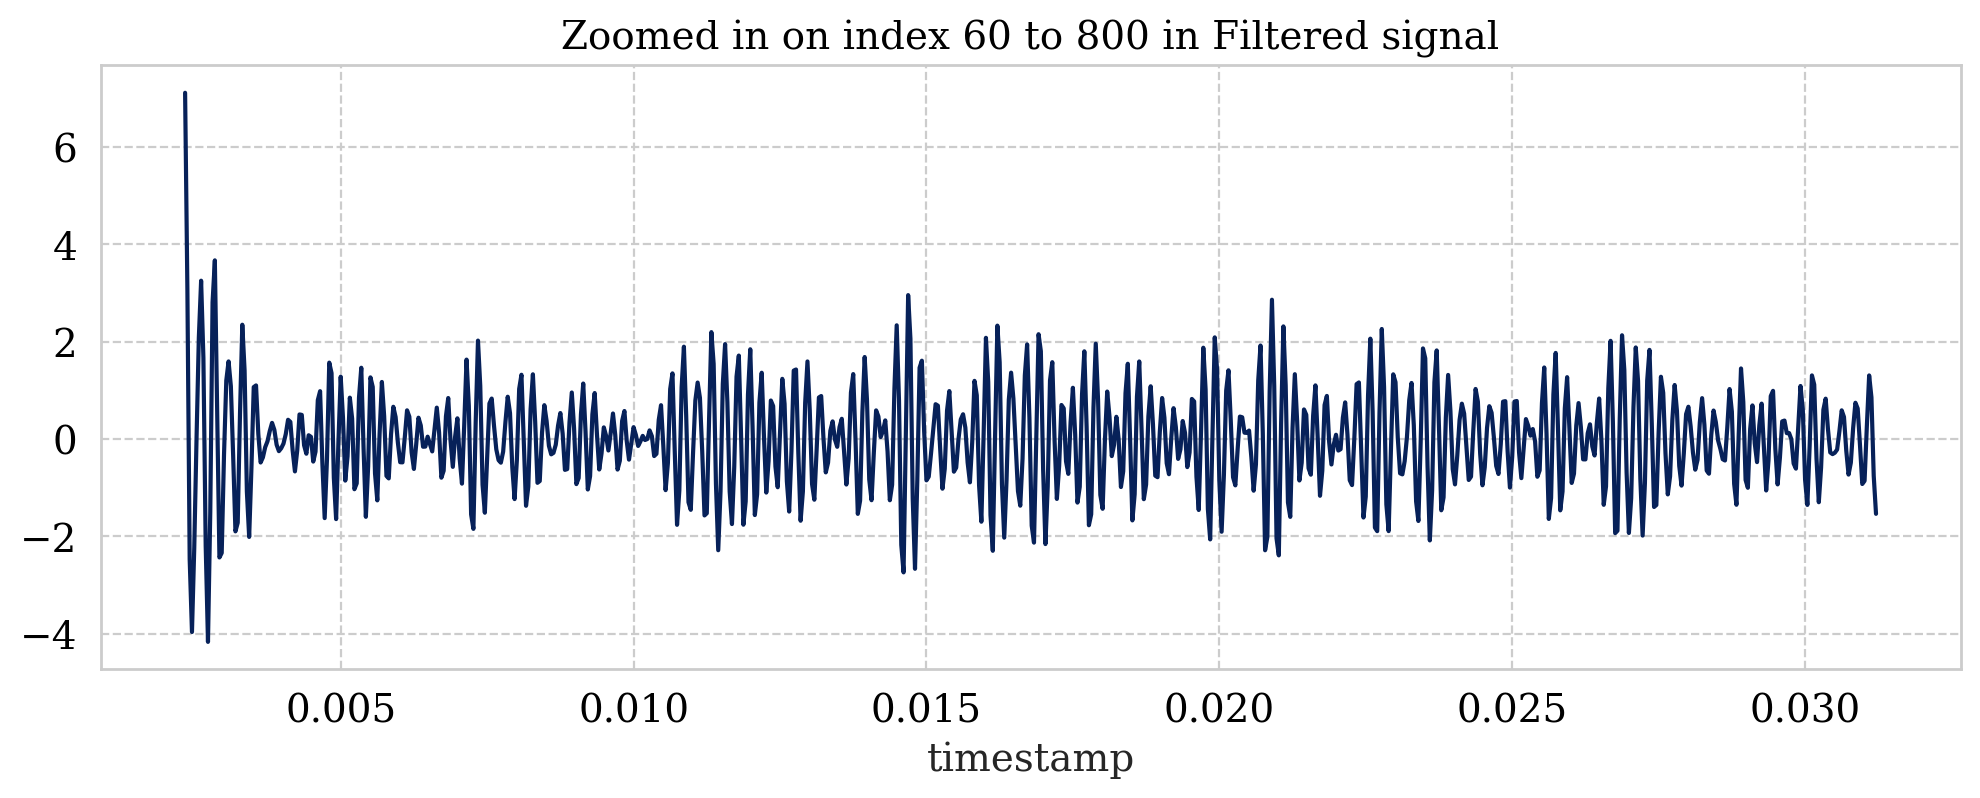

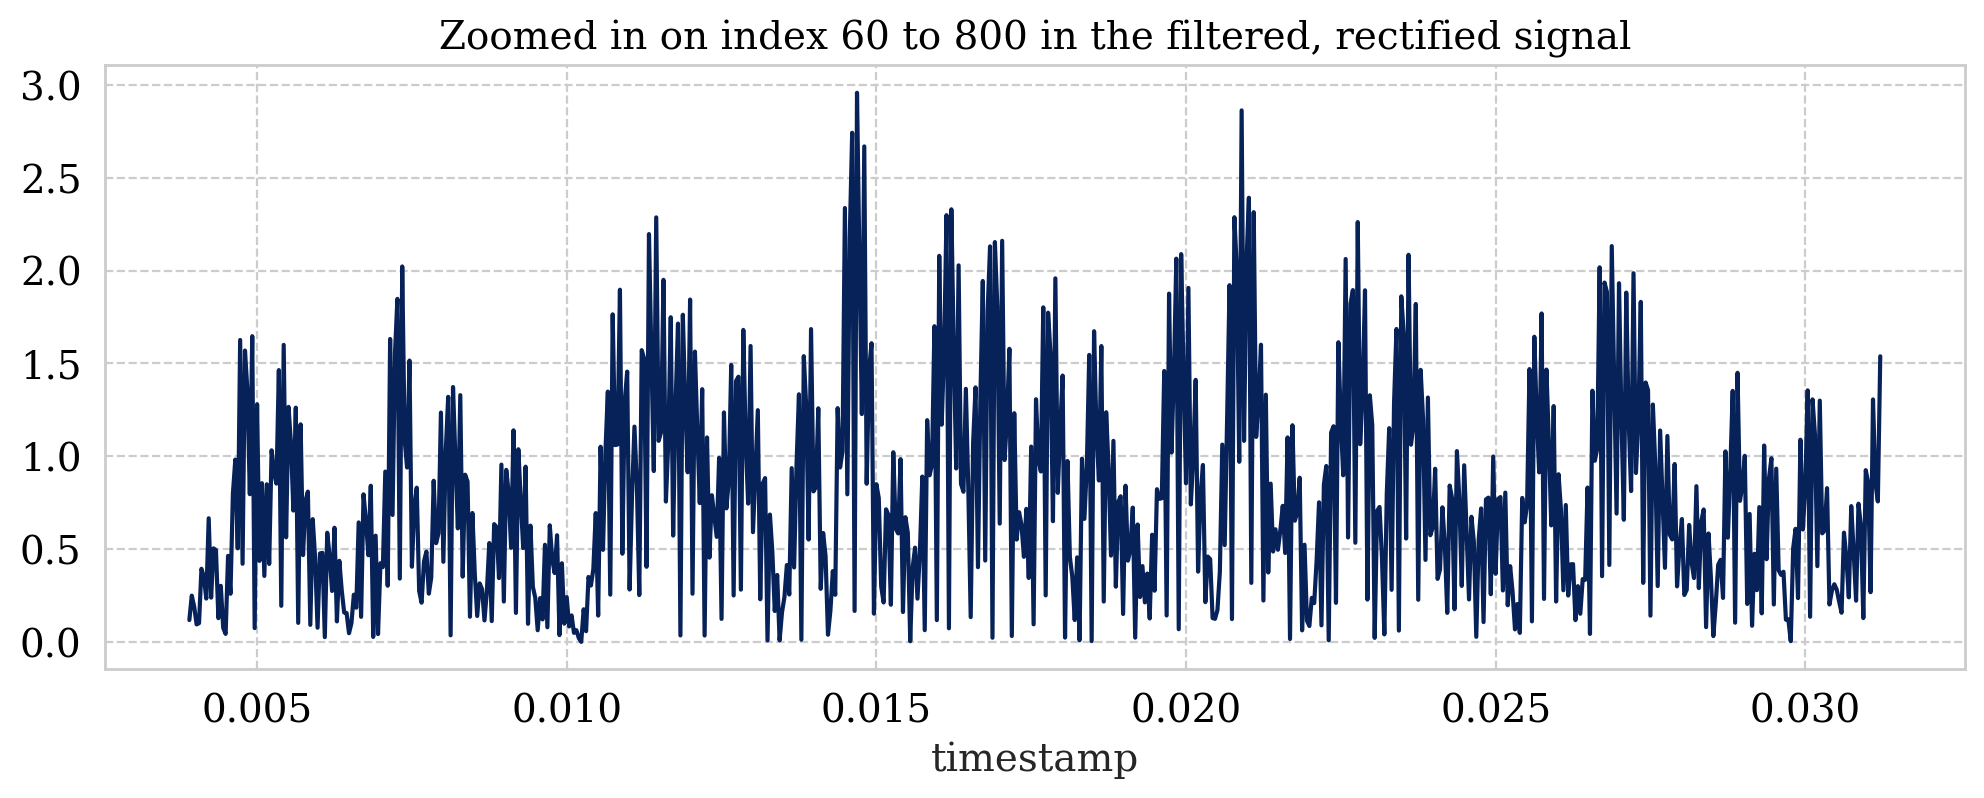

In [158]:
lowcut = 4000
highcut = 6000

stl_index = len(times_wt4) - 2 # Second to last
fs = fs # already defined
perform_envelope_process(times_wt4[stl_index],vib_signal_wt4[stl_index], fs,'GbxHssRr', lowcut, highcut)

## lowcut = 5000, highcut = 6000

### First interval

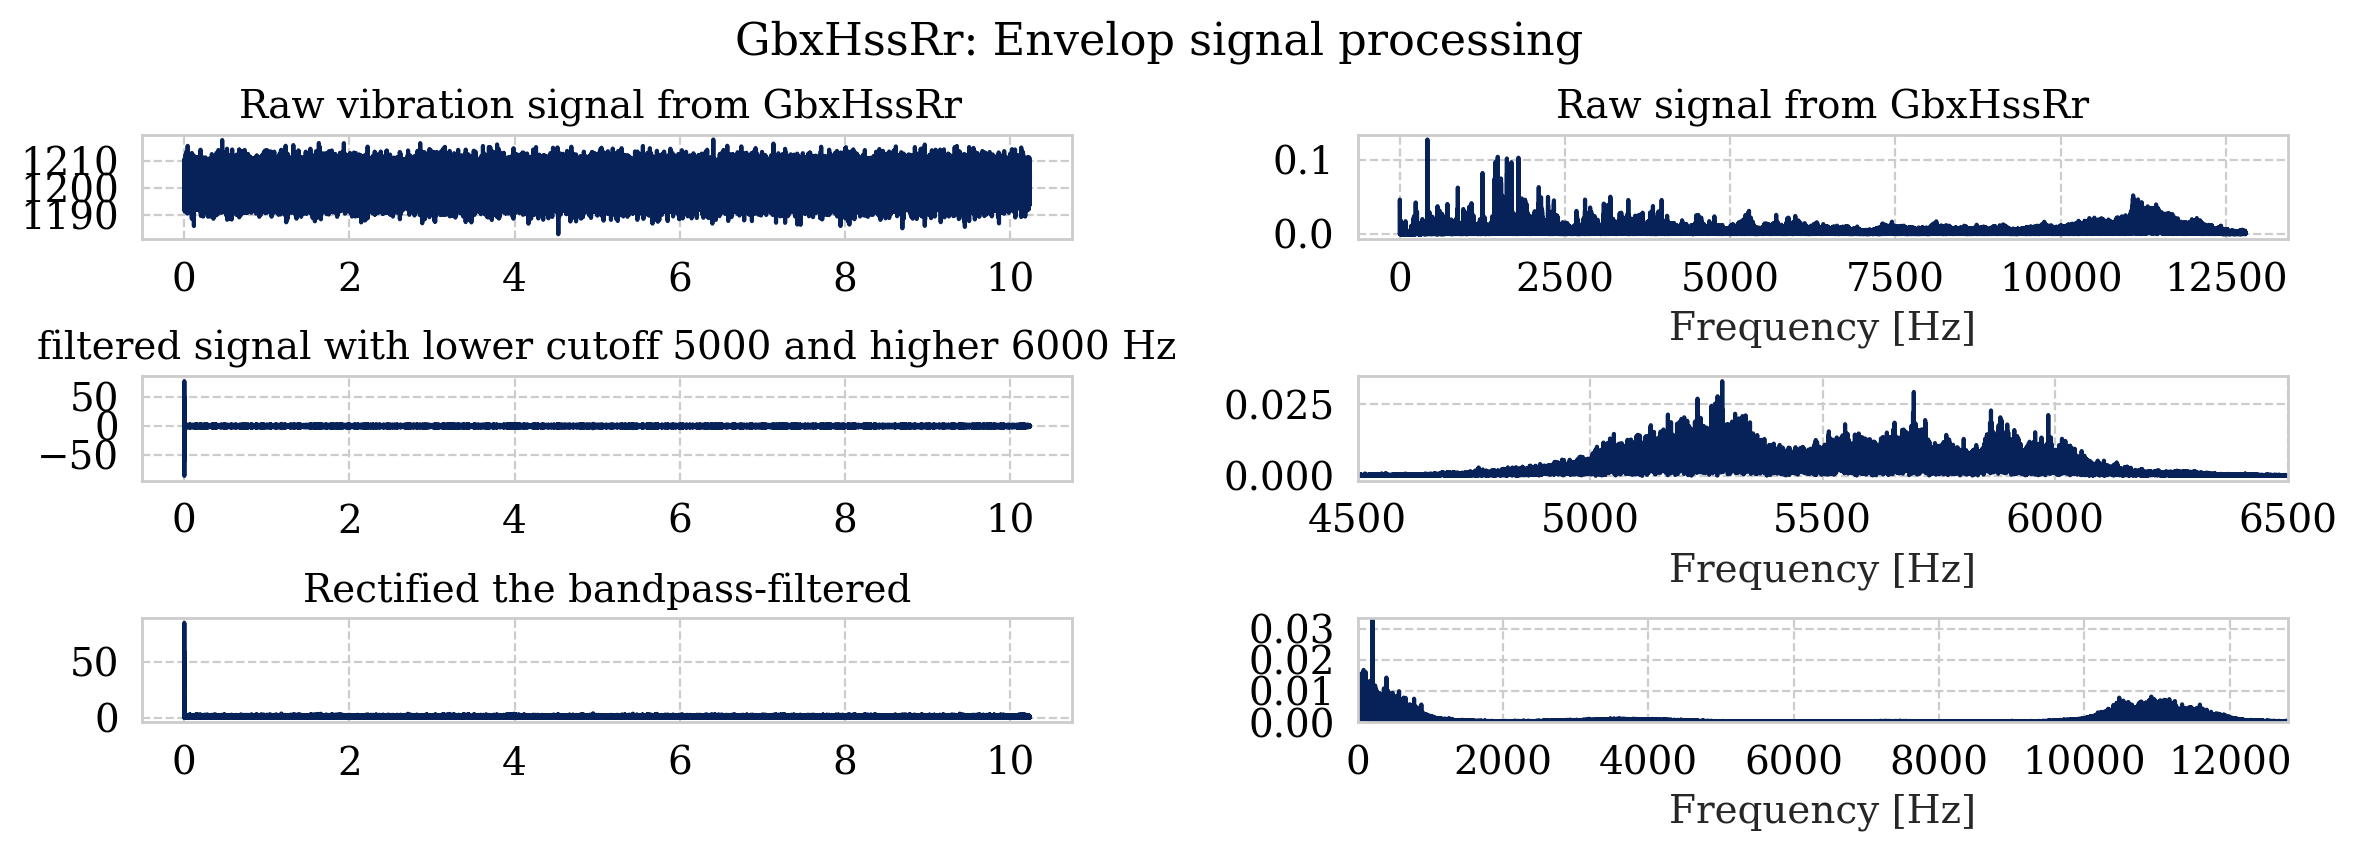

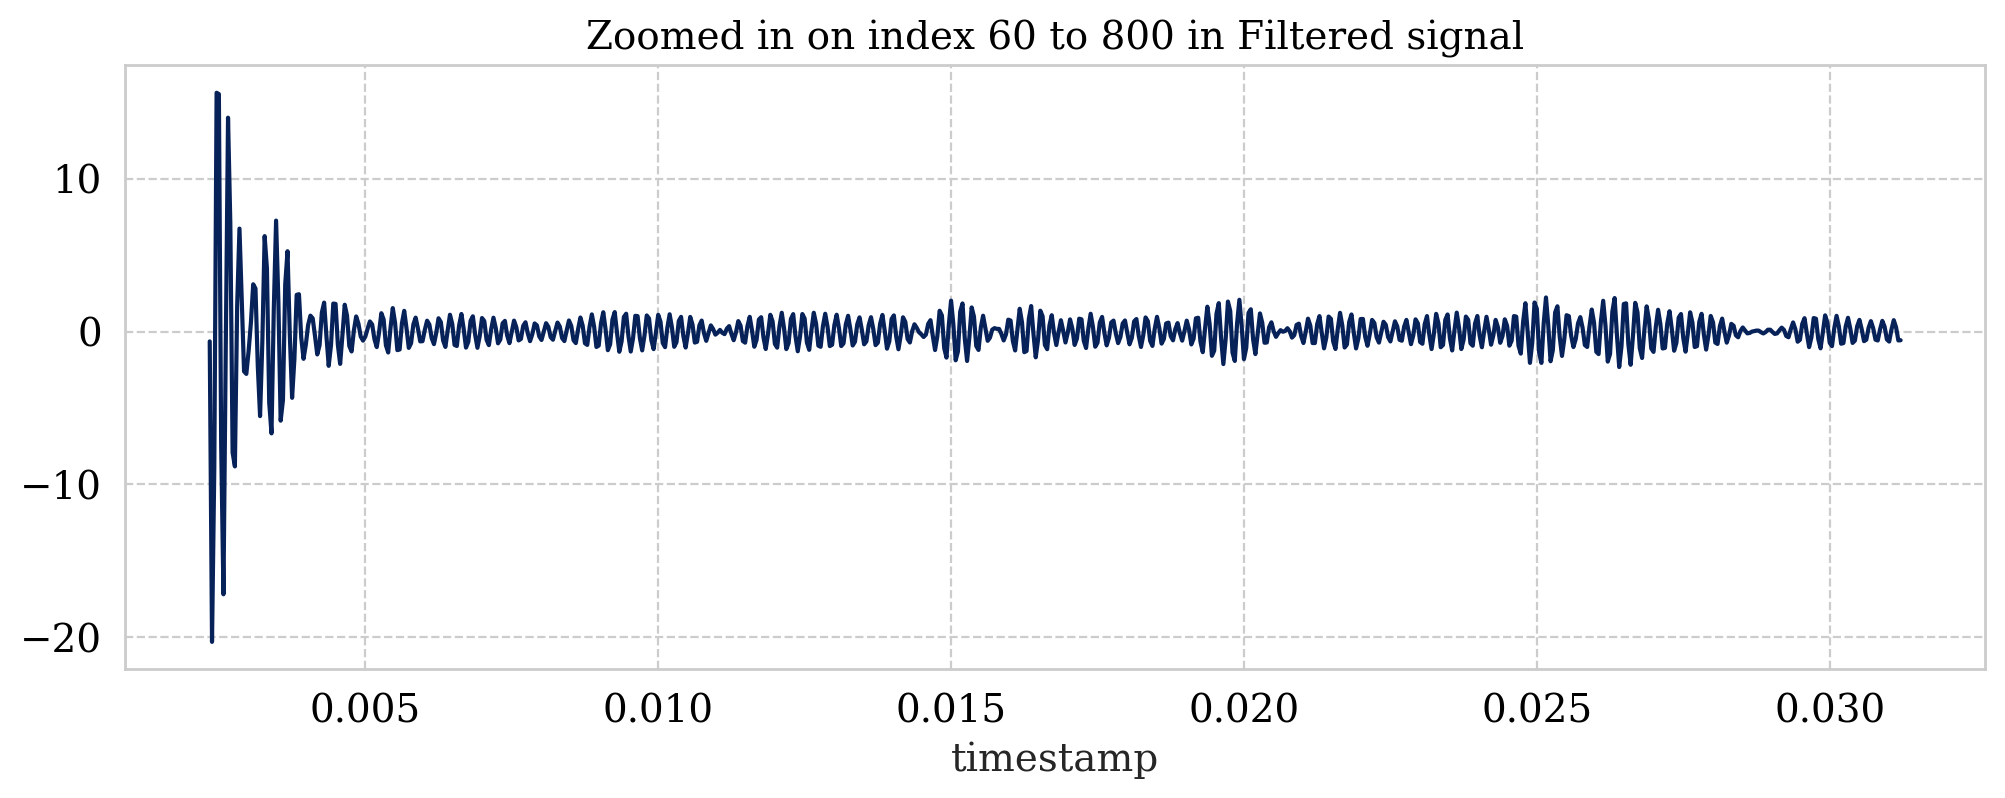

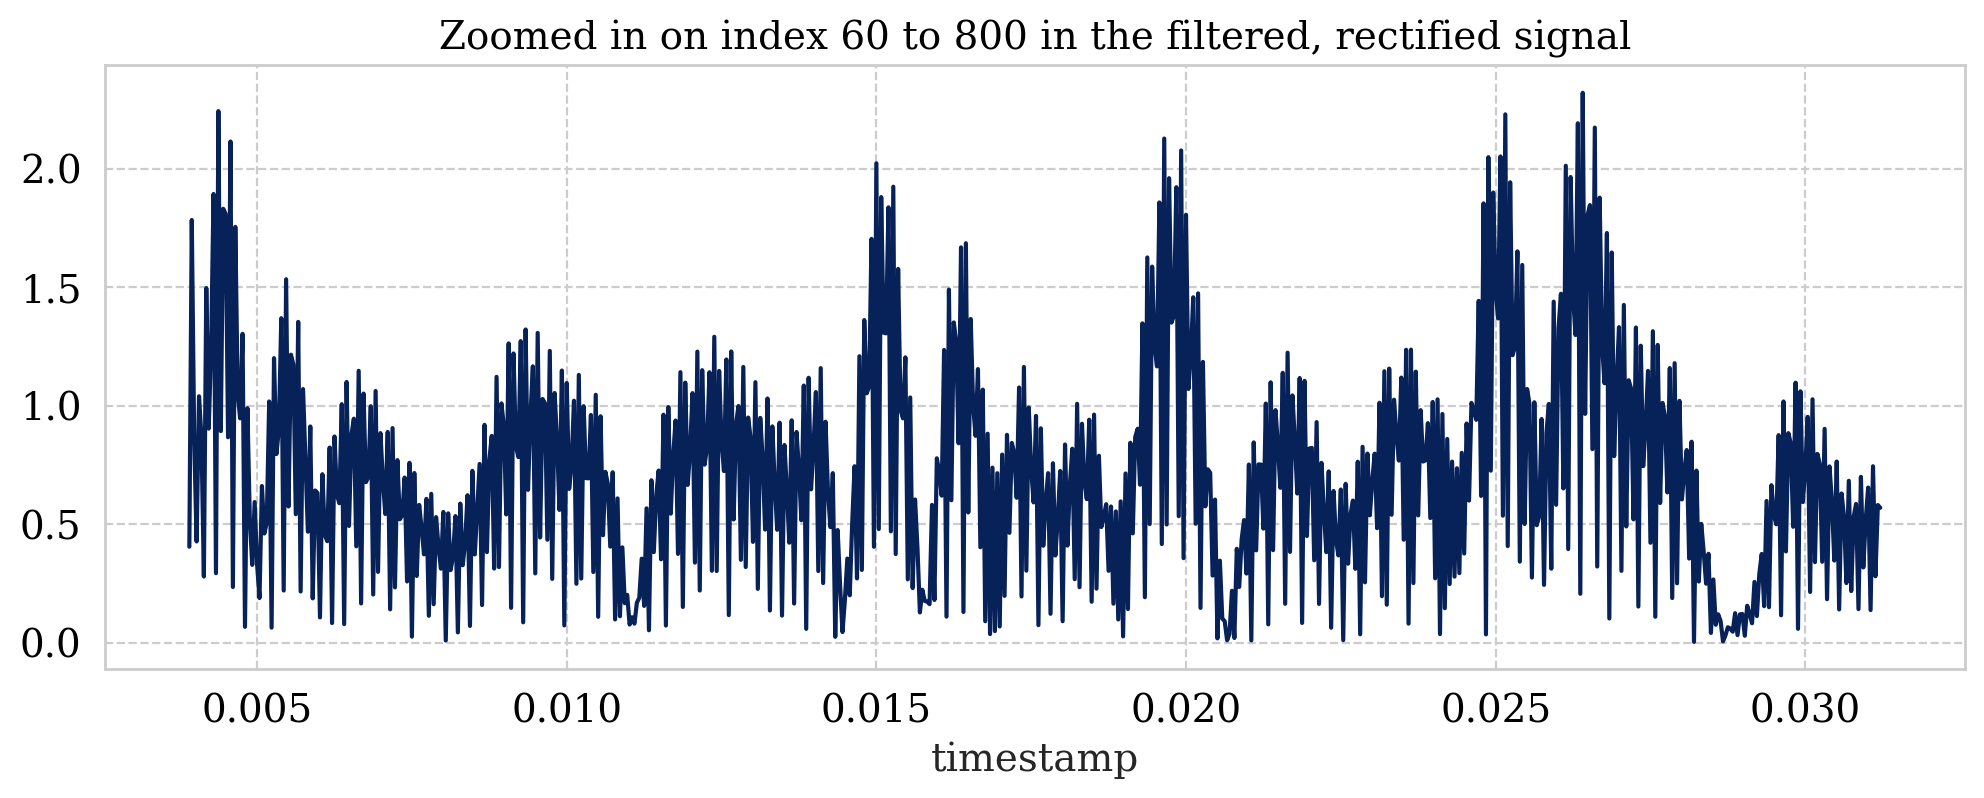

In [159]:
lowcut = 5000
highcut = 6000

perform_envelope_process(times_wt4[0],vib_signal_wt4[0], fs,'GbxHssRr', lowcut, highcut)

### Last interval

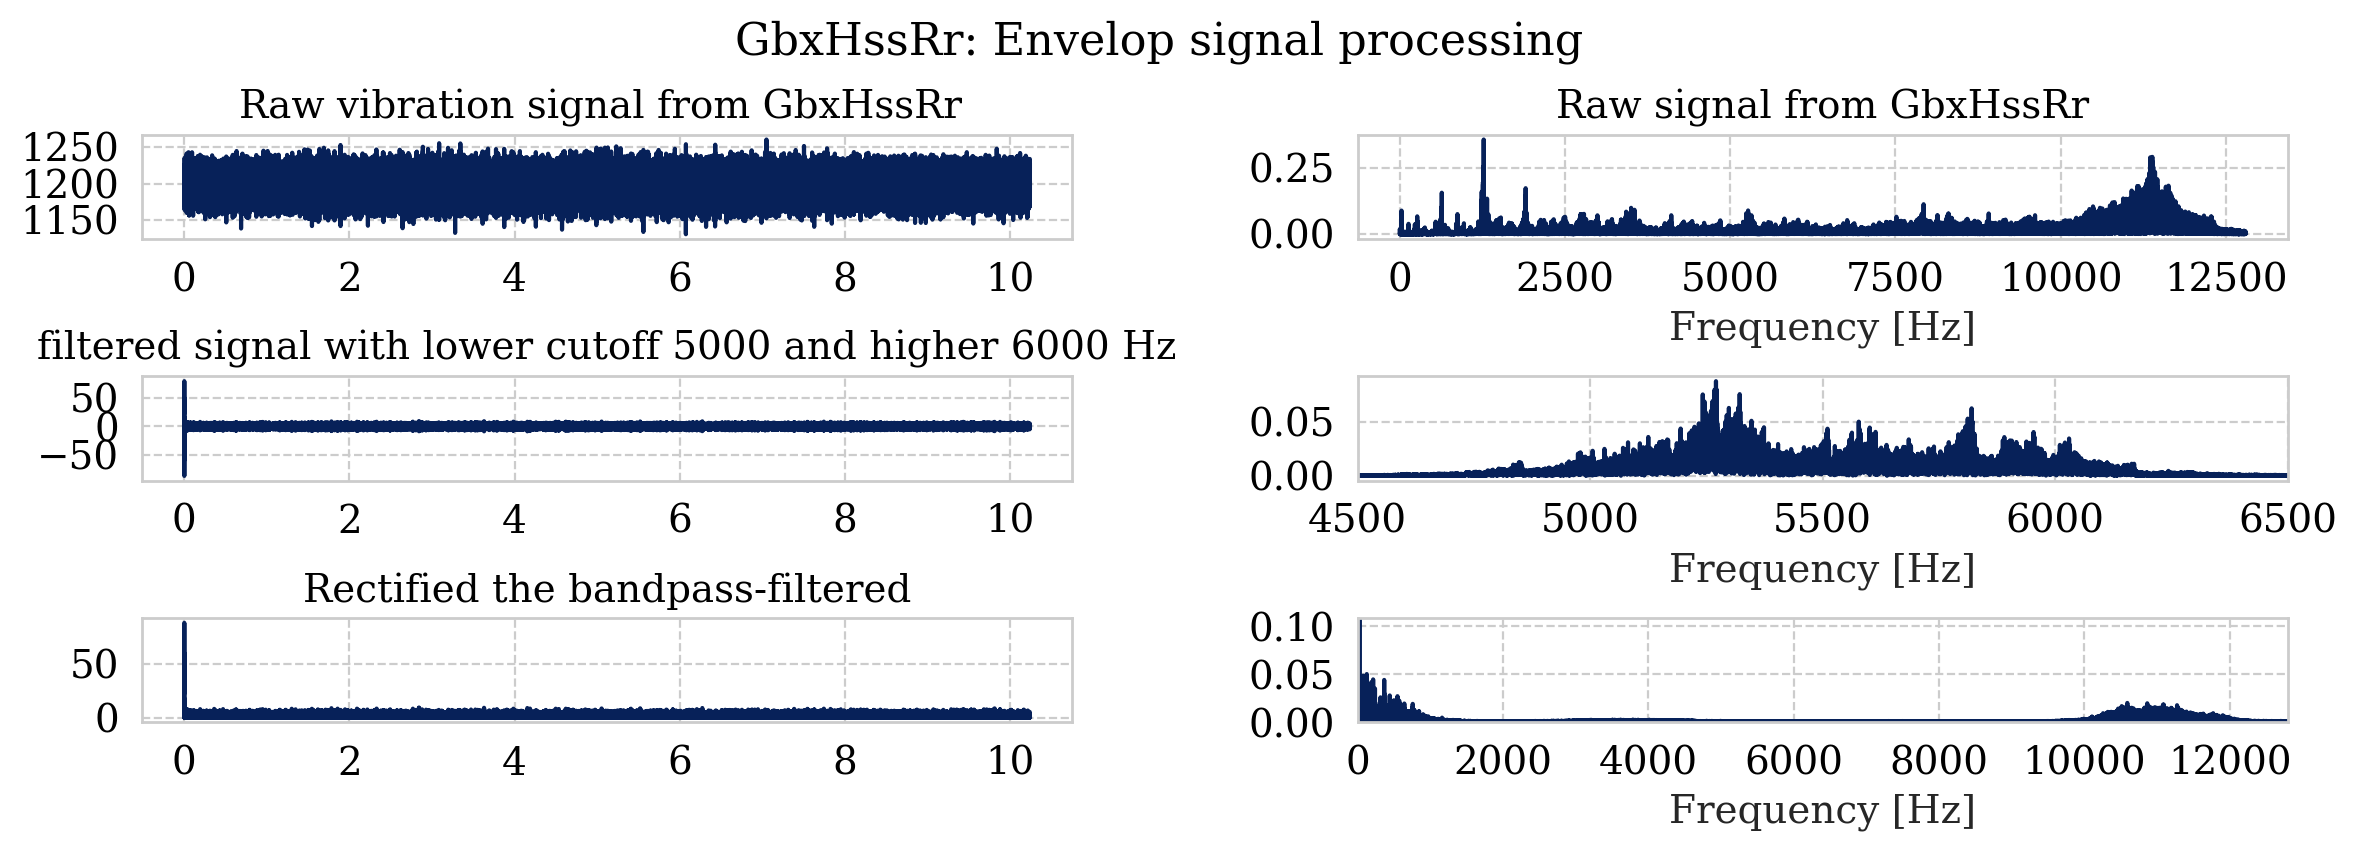

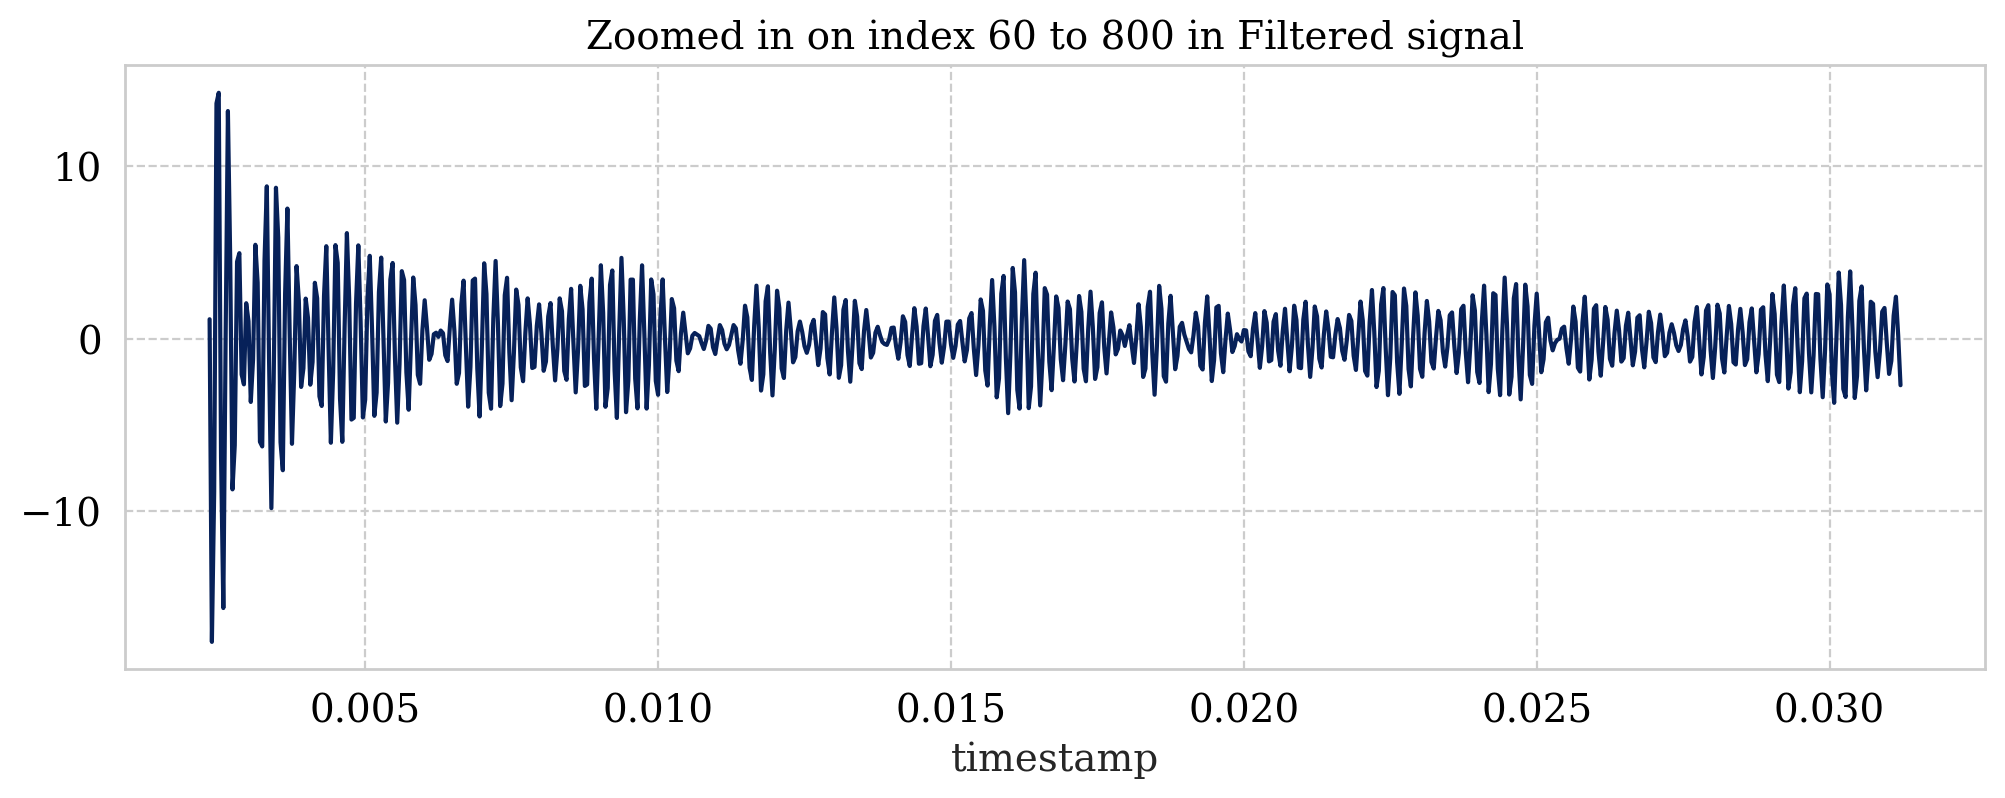

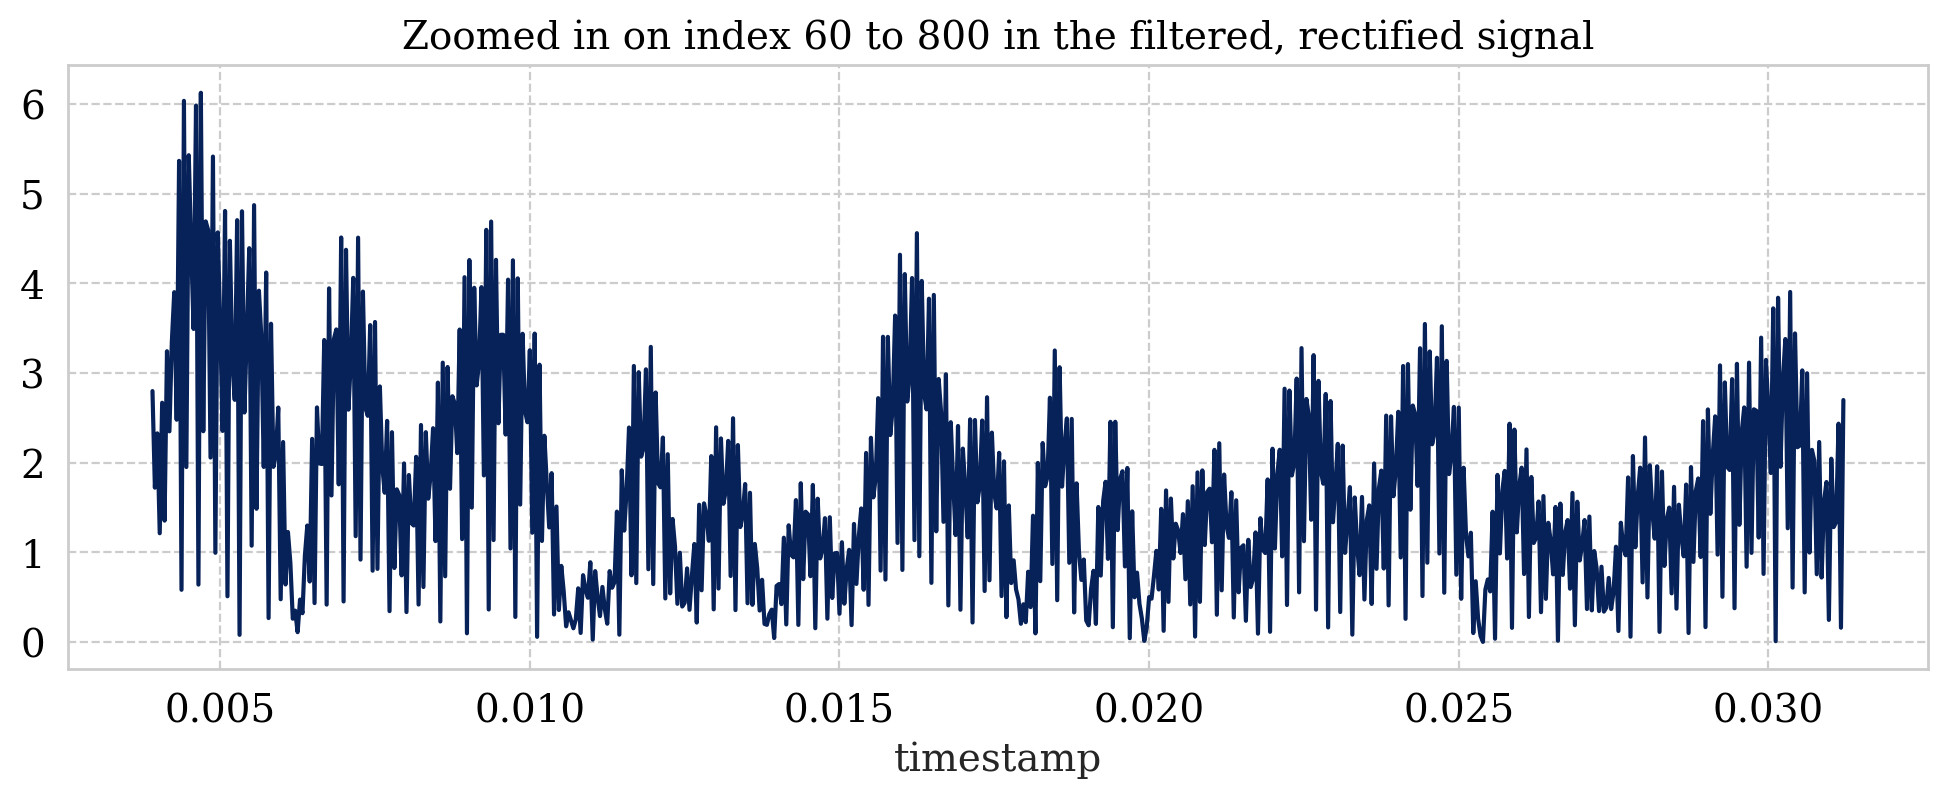

In [160]:
lowcut = 5000
highcut = 6000

perform_envelope_process(times_wt4[-1],vib_signal_wt4[-1], fs,'GbxHssRr', lowcut, highcut)

### Second to last interval Bandpass (5000, 6000 Hz)

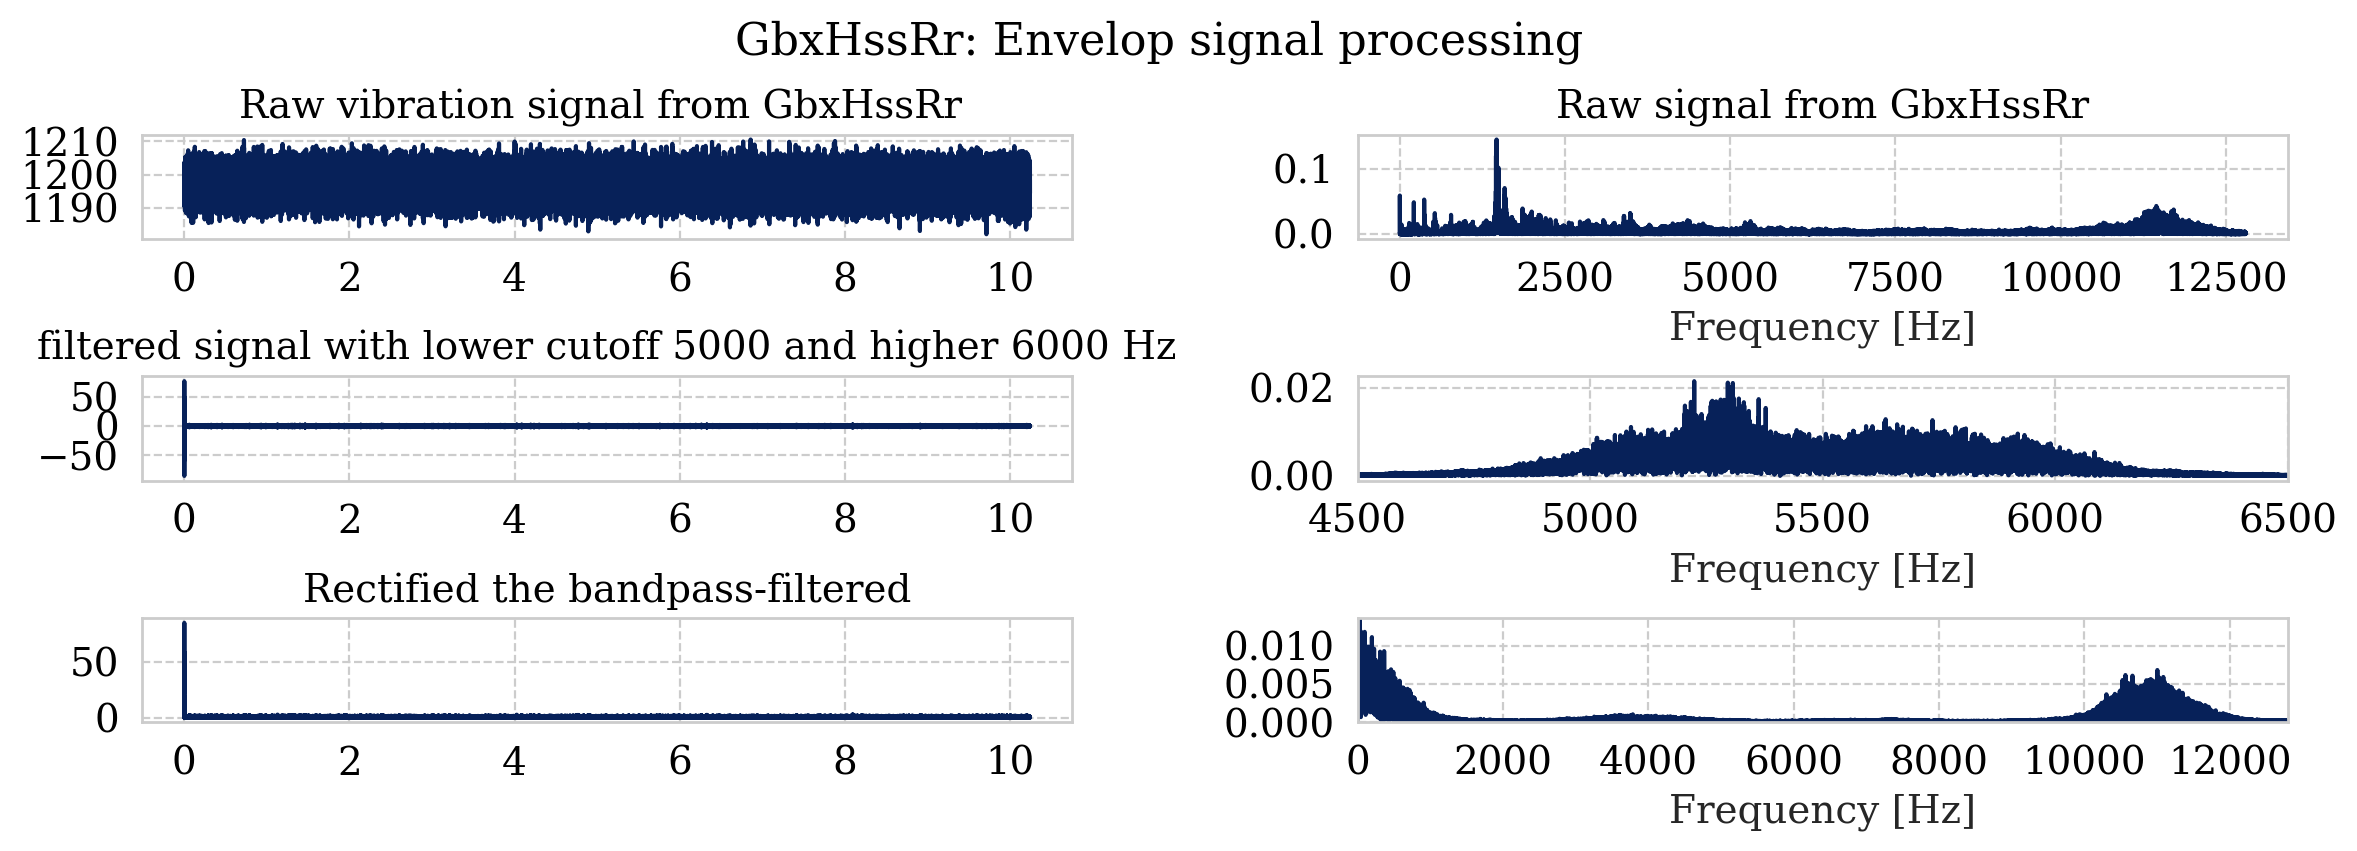

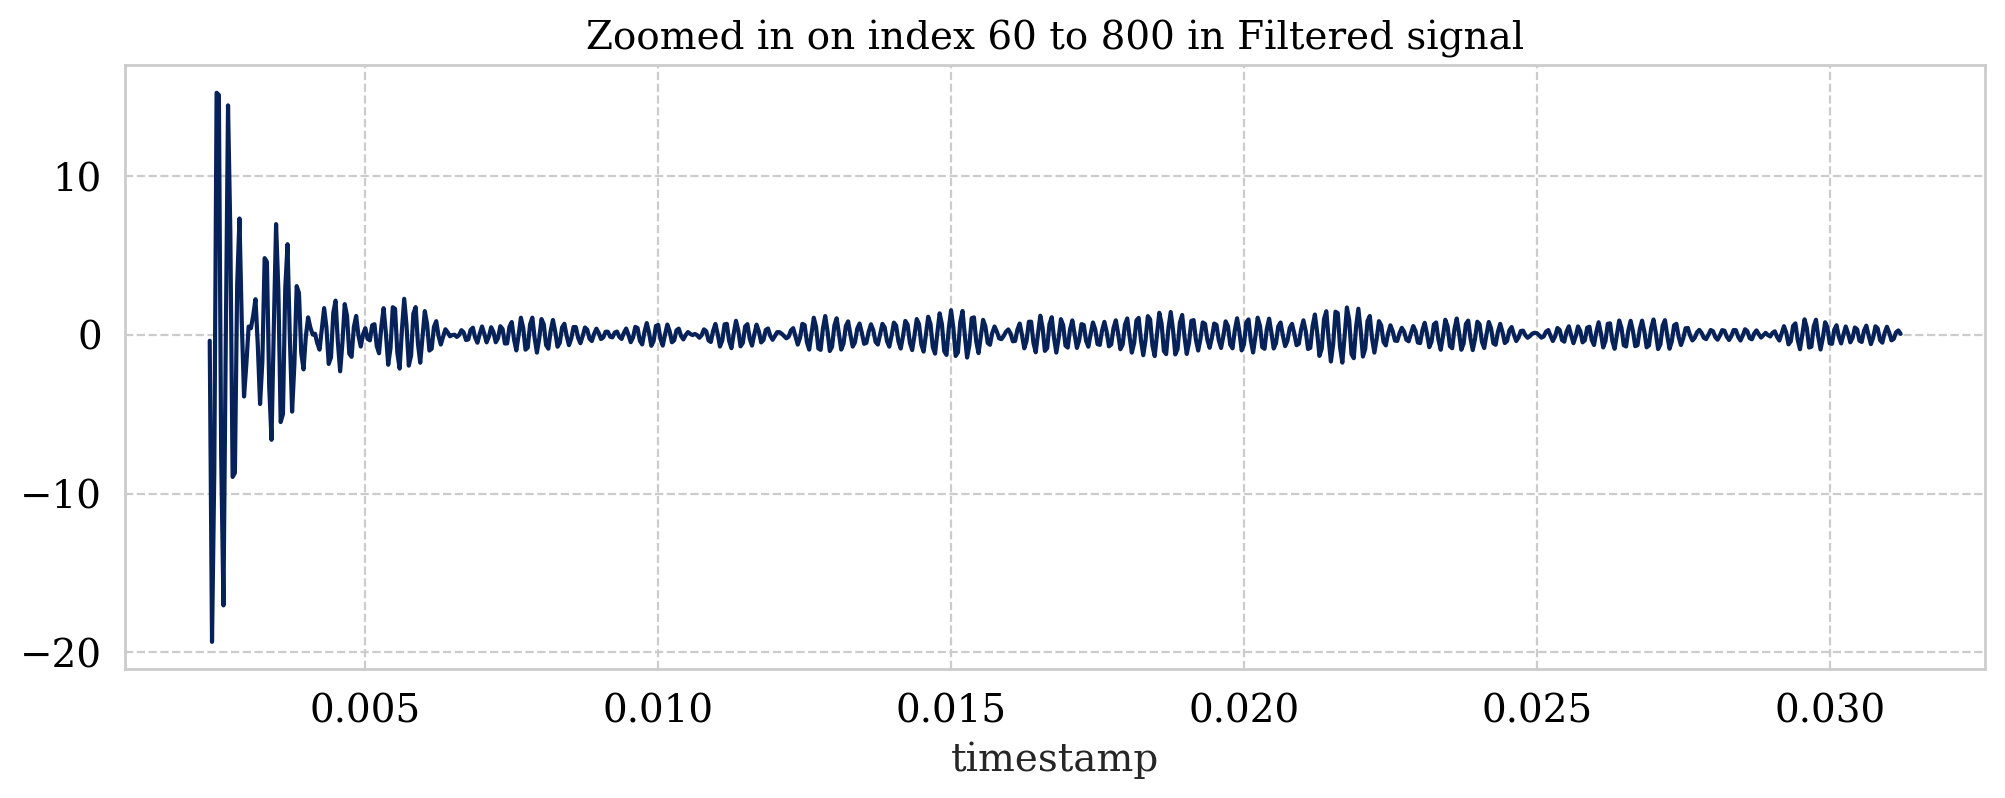

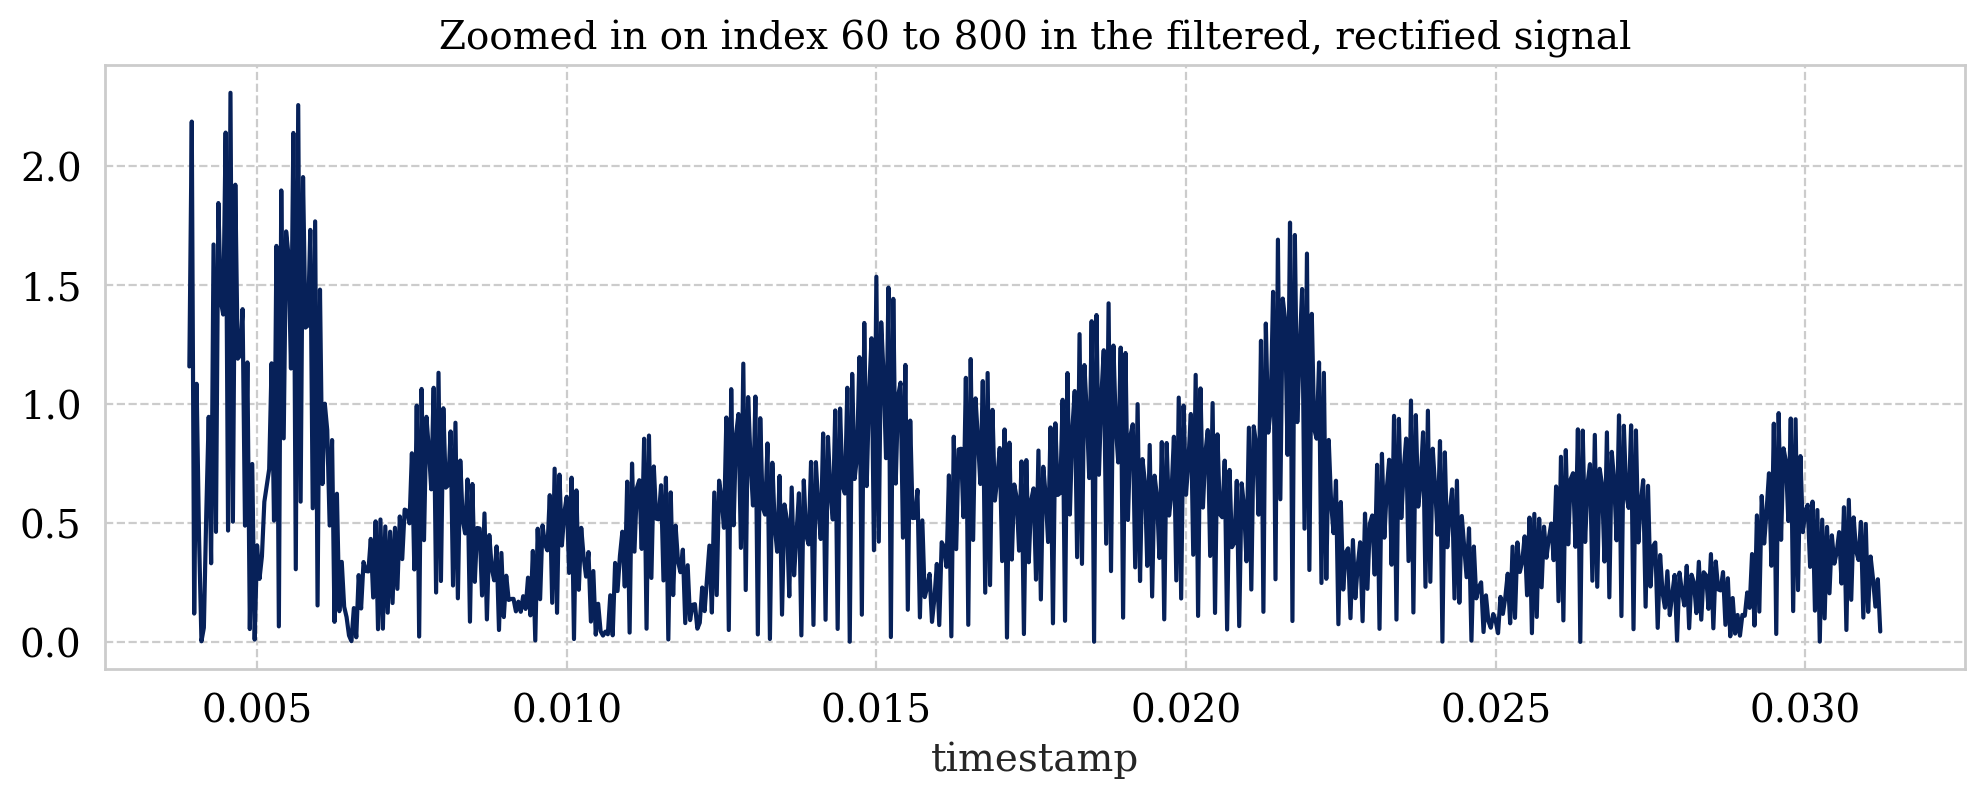

In [161]:
stl_index = len(times_wt4) - 2 # Second to last
lowcut = 5000
highcut = 6000

perform_envelope_process(times_wt4[stl_index],vib_signal_wt4[stl_index], fs,'GbxHssRr', lowcut, highcut)

## Another type of filter

In [124]:
def hp_filter(amplitudes, lower_freq_limit):
    sig = amplitudes
    fig, (ax2) = plt.subplots(1, 1, sharex=True)
    sos = signal.butter(10, lower_freq_limit, 'hp', fs=1000, output='sos')
    filtered = signal.sosfilt(sos, sig)
    ax2.plot(t, filtered)
    ax2.set_title(f'After {lower_freq_limit} Hz high-pass filter')
    ax2.axis([0, 1, -2, 2])
    ax2.set_xlabel('Time [seconds]')
    plt.show()
    perform_fft(filtered, t)

def lp_filter(amplitudes, upper_freq_limit):
    sig = amplitudes
    fig, (ax2) = plt.subplots(1, 1, sharex=True)
    sos = signal.butter(10, upper_freq_limit, 'lp', fs=1000, output='sos')
    filtered = signal.sosfilt(sos, sig)
    ax2.plot(t, filtered)
    ax2.set_title(f'After {upper_freq_limit} Hz high-pass filter')
    ax2.axis([0, 1, -2, 2])
    ax2.set_xlabel('Time [seconds]')
    plt.tight_layout()
    plt.show()
    perform_fft(filtered, t)

hp_filter(sig,250)
lp_filter(sig,50)


NameError: name 'sig' is not defined

In [ ]:
sos = signal.butter(10, 15, 'hp', fs=1000, output='sos')